# Imports

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools    import jarque_bera
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import yeojohnson, yeojohnson_normmax
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from xgboost import XGBRegressor
import shap

import joblib
from joblib import Parallel, delayed, parallel_backend

from tqdm import tqdm

c:\Users\aatis\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global Settings & Functions

In [3]:
cv_window = 60  # Initial window for cross-validation
cv_step = 30    # Step size for cross-validation

warnings.filterwarnings('ignore')

In [4]:
def winsorize_yj(
    series: pd.Series,
    limits: tuple = (0.01, 0.01)
) -> tuple[np.ndarray, dict]:
    """
    Winsorizes the series, shifts it to be strictly positive, 
    and applies the Yeo-Johnson transformation.

    Parameters
    ----------
    series : pd.Series
        Input time series to transform.
    limits : tuple, default (0.01, 0.01)
        Tuple specifying the lower and upper percentile limits 
        for winsorization.

    Returns
    -------
    transformed : np.ndarray
        Transformed series after winsorization, shift, and Yeo-Johnson transform.
    params : dict
        Dictionary containing the transformation parameters:
        - 'lambda': Optimal lambda for the Yeo-Johnson transformation.
        - 'shift': Amount added to shift data to strictly positive.
    """
    w = winsorize(series.values, limits=limits)  # Winsorize outliers
    s_w = pd.Series(w, index=series.index)

    shift = -s_w.min() + 1e-6  # Ensure data is strictly positive
    shifted = s_w + shift

    lam = yeojohnson_normmax(shifted)  # Find optimal lambda
    transformed = yeojohnson(shifted, lmbda=lam)

    return transformed, {"lambda": lam, "shift": shift}

In [5]:
def inv_yj(arr: np.ndarray, params: dict) -> np.ndarray:
    """
    Applies the inverse of the Yeo-Johnson transformation.

    Parameters
    ----------
    arr : np.ndarray
        Transformed array to invert.
    params : dict
        Dictionary containing transformation parameters:
        - 'lambda': Lambda used during the forward transformation.
        - 'shift': Shift applied before transformation.

    Returns
    -------
    y : np.ndarray
        Original array, inverse-transformed and unshifted.
    """
    lam = params["lambda"]
    sh = params["shift"]

    x = np.asarray(arr, dtype=float)
    y = np.zeros_like(x)

    # Positive branch of the inverse
    pos = x >= 0
    if lam != 0:
        y[pos] = np.power(x[pos] * lam + 1, 1 / lam) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1

    # Negative branch of the inverse
    neg = x < 0
    if lam != 2:
        y[neg] = 1 - np.power(-x[neg] * (2 - lam) + 1, 1 / (2 - lam))
    else:
        y[neg] = 1 - np.exp(-x[neg])

    return y - sh

# Data Loading & Visualisation

### Data Loading

In [85]:
# Load the data
etf_data = pd.read_excel('../data/etf_data_2.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Convert Tracking Error to basis points
etf_data['Tracking_Error'] = etf_data['Tracking_Error']*10000       

# Check the data
display(etf_data.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,SPY,82.933676,83.070128,79.392844,80.614067,1184211500,-0.022420,-0.025290,0.006447,28.70,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-02-01,SPY,80.675479,83.008700,80.573141,82.299217,1025608400,0.020904,0.018903,0.006730,20.01,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-03-01,SPY,82.428789,84.086674,79.622477,80.793709,1330548800,-0.018293,-0.019118,0.006339,8.25,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-04-01,SPY,81.252579,81.684066,77.773181,79.280006,1633318500,-0.018735,-0.020109,0.009503,13.73,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-05-01,SPY,79.499193,82.362160,78.629339,81.834778,1334647300,0.032225,0.029952,0.006390,22.73,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [86]:
# Get information about the data
print("ETF Data Info:")
display(etf_data.describe())
print("\nMacro Data Info:")
display(macro.describe())

ETF Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,7176.000000,7176.000000,7176.000000,7176.000000,7.176000e+03,7176.000000,7176.000000,7176.000000,7176.000000,7.176000e+03,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176,7176.000000,7176.000000
mean,86.766325,90.172714,83.285888,87.422013,3.038787e+08,0.009043,0.007561,0.011833,14.823686,1.411339e+11,230.974559,24.443200,144.618729,1.008428,16.770903,2000-03-15 16:27:17.458193920,0.004031,634.692308
min,4.405518,5.344535,3.543700,4.580290,3.784000e+05,-0.343710,-0.351986,0.001958,-1063.270000,7.002211e+08,51.012780,15.364081,45.000000,0.550000,3.000000,1993-01-22 00:00:00,0.000286,26.000000
25%,29.221763,30.469714,27.823003,29.566423,1.965720e+07,-0.019093,-0.020340,0.007127,2.617500,1.106325e+10,83.582250,20.007551,110.000000,0.980000,8.000000,1998-12-16 00:00:00,0.001727,50.000000
50%,54.945025,57.069586,52.716665,55.417520,7.013130e+07,0.013325,0.011668,0.009758,13.445000,2.627259e+10,155.905620,23.717783,129.000000,1.030000,16.000000,2000-05-22 00:00:00,0.005014,391.000000
75%,105.872270,108.983108,102.154641,106.245455,2.217607e+08,0.039673,0.038243,0.013736,25.905000,7.217285e+10,329.669600,27.027494,186.000000,1.120000,21.000000,2000-06-12 00:00:00,0.005802,1022.000000
max,610.746536,618.325438,580.050265,610.132324,1.188235e+10,0.307639,0.296553,0.086460,1520.780000,1.822973e+12,602.602500,38.760517,350.000000,1.470000,39.000000,2011-12-20 00:00:00,0.007566,3559.000000
std,89.140964,92.579945,85.819490,89.985562,7.213975e+08,0.052470,0.053142,0.008136,65.798246,3.467729e+11,169.373865,5.924201,68.635454,0.205274,10.588061,NaN,0.002339,840.145388



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


### Plots

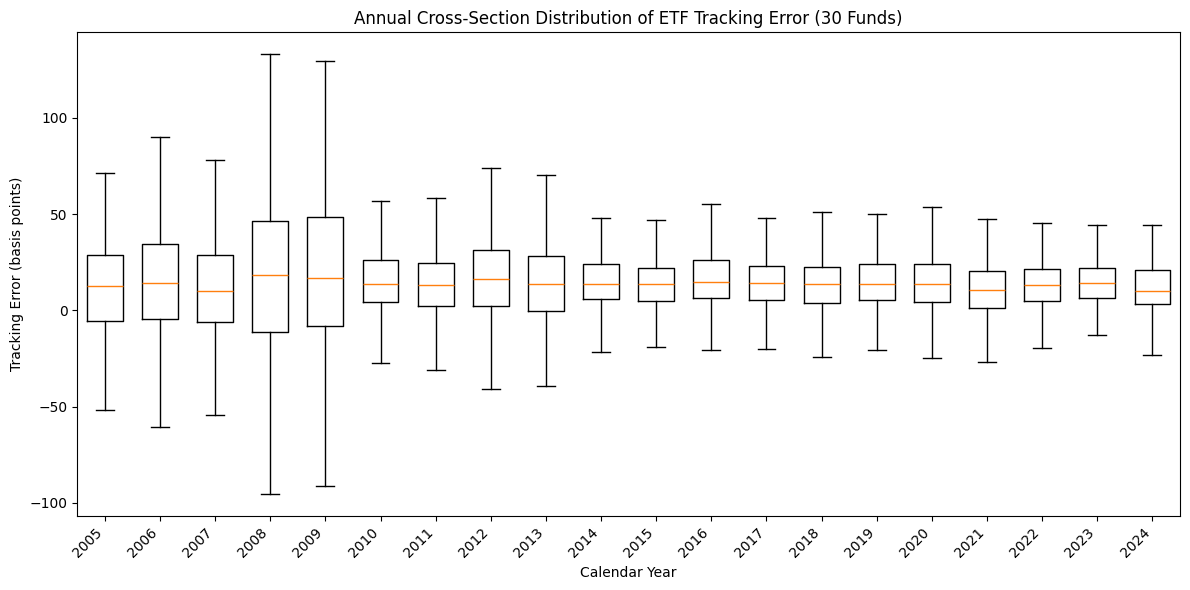

In [87]:
# Gather the Tracking Error (TE) values for each calendar year
ys_lists_bp = (
    etf_data
        .groupby(etf_data.index.year)['Tracking_Error']
        .apply(lambda x: (x * 1).tolist())  
)

# Create the strip of yearly box plots showing cross-sectional TE distribution
fig, ax = plt.subplots(figsize=(12, 6))

positions = range(len(ys_lists_bp))  # X-axis positions for each year's box plot
ax.boxplot(
    ys_lists_bp.tolist(),   # List of lists of TE values per year
    positions=positions,    # Set positions explicitly to match year order
    widths=0.65,
    showfliers=False        # Toggle to True to display individual outlier dots
)

# Set x-axis tick labels to corresponding calendar years
ax.set_xticks(positions)
ax.set_xticklabels([str(y) for y in ys_lists_bp.index], rotation=45, ha='right')

# Title and axis labels
ax.set_title("Annual Cross-Section Distribution of ETF Tracking Error (30 Funds)")
ax.set_xlabel("Calendar Year")
ax.set_ylabel("Tracking Error (basis points)")

plt.tight_layout()
plt.show()

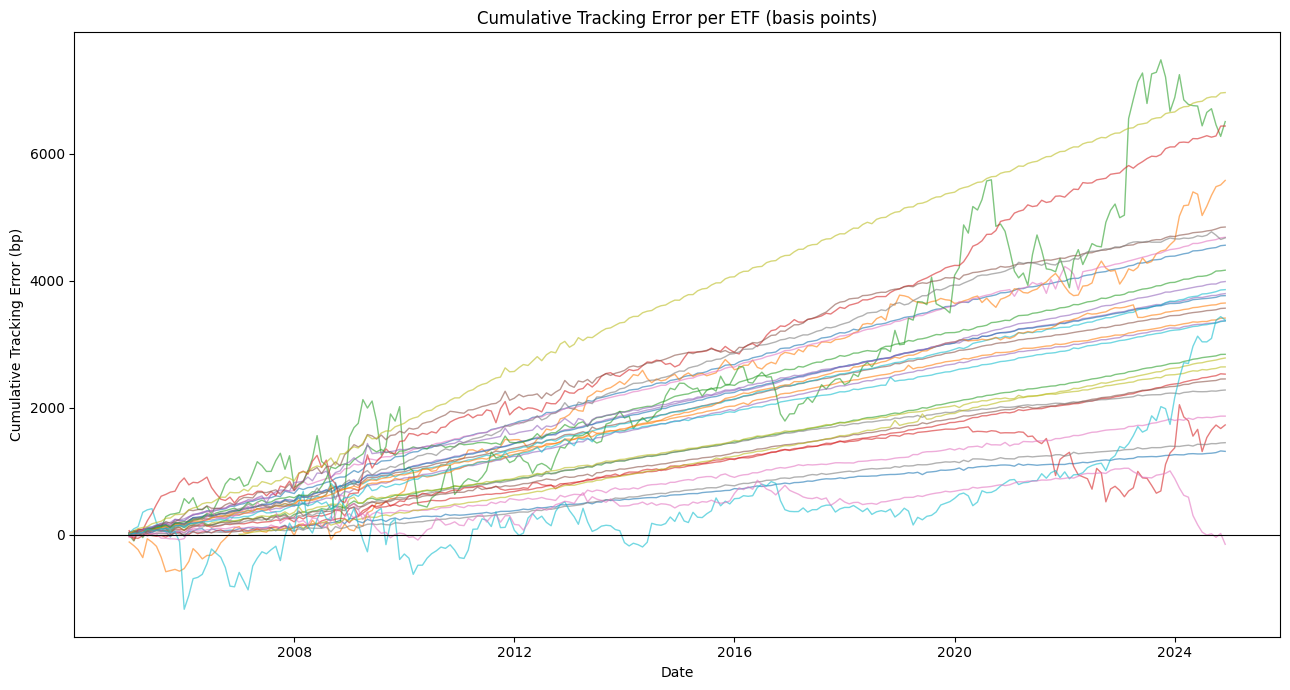

In [88]:
cum_te_df = etf_data.copy()
cum_te_df['TE_bp'] = cum_te_df['Tracking_Error'] 

# Compute running cumulative tracking error (bp) within each ETF
cum_te_df = cum_te_df.sort_values(['ETF_Ticker', 'Date'])
cum_te_df['Cum_TE_bp'] = cum_te_df.groupby('ETF_Ticker')['TE_bp'].cumsum()

# Reshape from long to wide format (keep last record if duplicates on same date)
wide = (
    cum_te_df.pivot_table(index='Date',
                   columns='ETF_Ticker',
                   values='Cum_TE_bp',
                   aggfunc='last')
      .sort_index()
)

# Plot one semi-transparent line per ETF
plt.figure(figsize=(13, 7))
for col in wide.columns:
    plt.plot(wide.index, wide[col], linewidth=1, alpha=0.6)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Cumulative Tracking Error per ETF (basis points)')
plt.xlabel('Date')
plt.ylabel('Cumulative Tracking Error (bp)')
plt.tight_layout()
plt.show()

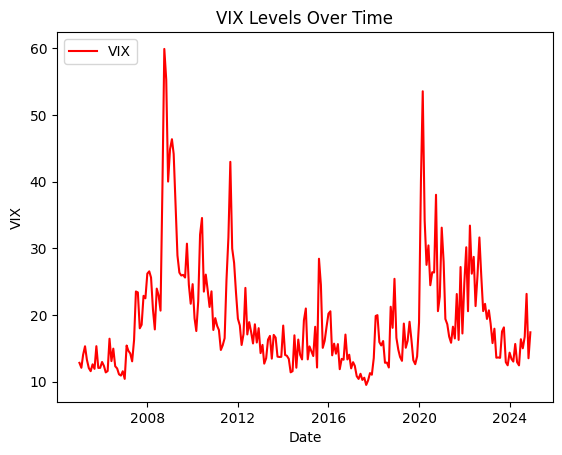

In [89]:
# VIX 
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

lines1, labs1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labs1, loc='upper left')
plt.title('VIX Levels Over Time')
plt.show()

# SARIMA-GARCH Model Fitting

### SARIMA-GARCH Base Model

In [90]:
def fit_sarima_garch(
    series: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
) -> dict:
    """
    Fits a SARIMA model with expanding-window cross-validation, and
    optionally visualizes the final CV fold with GARCH-based 95% confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Time series to model.
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial training window for expanding-window CV.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for outlier treatment.
    seasonal_period : int
        Seasonal period for SARIMA.
    n_jobs : int
        Number of parallel jobs for CV folds.
    arima_jobs : int
        Number of parallel jobs inside each auto_arima fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    forecast_plot : bool
        If True, plots final CV fold forecast with GARCH 95% CI.

    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_metrics': Cross-validation performance metrics (MAE, MSE, R2).
        - 'forecast_df': DataFrame of forecasts vs actuals for all folds.
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation And Window Setup
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()
    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Worker
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end: int) -> tuple[float, float, float, pd.DataFrame]:
        """
        Perform a single CV fold: fit SARIMA, forecast, and evaluate.

        Parameters
        ----------
        end : int
            Index in the time series at which the training window ends.

        Returns
        -------
        tuple
            Tuple of (MAE, MSE, R2, forecast DataFrame) for this fold.
        """
        train = y.iloc[:end]
        test = y.iloc[end:end + horizon]

        # Winsorize and transform the training data
        tr_t, tf_par = winsorize_yj(train, winsor_limits)

        # Fit SARIMA model to transformed series
        model = auto_arima(
            tr_t,
            seasonal=True,
            m=seasonal_period,
            information_criterion="aic",
            max_p=max_pq,
            max_q=max_pq,
            max_d=max_dD,
            max_P=max_pq,
            max_Q=max_pq,
            max_D=max_dD,
            stepwise=True,
            maxiter=20,
            suppress_warnings=True,
            error_action="ignore",
            n_jobs=arima_jobs,
        )

        # Forecast and inverse-transform to original scale
        forecast = inv_yj(model.predict(horizon), tf_par)

        # Collect forecast and actuals in DataFrame for diagnostics
        fc_df = pd.DataFrame({
            "Date": test.index,
            "Forecast": forecast,
            "Actual": test.values,
            "horizon": horizon
        })

        return (
            mean_absolute_error(test, forecast),
            mean_squared_error(test, forecast),
            r2_score(test, forecast),
            fc_df
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Execute Cross-Validation Folds In Parallel
    # ─────────────────────────────────────────────────────────────
    res_list = Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends)
    mae, mse, r2, fc_dfs = zip(*res_list)

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": list(mae), "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": list(mse), "mean": np.mean(mse), "std": np.std(mse)},
        "R2": {"values": list(r2), "mean": np.mean(r2), "std": np.std(r2)},
    }

    forecast_df = pd.concat(fc_dfs, ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 3. Plot Final Fold Forecast With GARCH Confidence Intervals
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        end = fold_ends[-1]
        train = y.iloc[:end]
        test = y.iloc[end:end + horizon]

        tr_t, tf_par = winsorize_yj(train, winsor_limits)
        model = auto_arima(
            tr_t,
            seasonal=True,
            m=seasonal_period,
            information_criterion="aic",
            max_p=max_pq,
            max_q=max_pq,
            max_d=max_dD,
            max_P=max_pq,
            max_Q=max_pq,
            max_D=max_dD,
            stepwise=True,
            maxiter=20,
            suppress_warnings=True,
            error_action="ignore",
            n_jobs=arima_jobs,
        )

        fc = inv_yj(model.predict(horizon), tf_par)

        # Estimate forecast uncertainty using GARCH(1,1)
        resid = pd.Series(model.arima_res_.resid,
                          index=train.index[-len(model.arima_res_.resid):])
        z = resid / resid.std()
        gmod = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
        var_h = gmod.forecast(horizon=horizon, reindex=False).variance.iloc[-1].values
        sigma_f = np.sqrt(var_h) * resid.std()

        # Plot recent historical points and forecast with error bars
        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev], test.values],
                 "-o", color="C0", zorder=2, label="Actual")
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev].values, fc],
                 "--o", color="C1", zorder=1, label="Forecast")
        plt.errorbar(test.index, fc, yerr=1.96 * sigma_f,
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")

        plt.title(f"Final CV Fold: SARIMA–GARCH Actual Values + {horizon}-Step Forecast")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 4. Return Cross-Validation Metrics
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "forecast_df": forecast_df
    }

### SARIMA-GARCH Panel Fit

In [91]:
def run_sarima_garch_panel(
    panel_df: pd.DataFrame,
    target_col: str        = "Tracking_Error",
    ticker_col: str        = "ETF_Ticker",
    date_col: str          = "Date",
    horizon: int           = 3,
    cv_window: int         = 60,
    cv_step: int           = 30,
    winsor_limits: tuple   = (0.01, 0.01),
    seasonal_period: int   = 12,
    n_jobs: int            = -1,
    arima_jobs: int        = 1,
    max_pq: int            = 5,
    max_dD: int            = 3,
    plot_ticker: str | None = None,
):
    """
    Run SARIMA–GARCH expanding-window CV across a panel of ETFs.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Long-format panel of ETF data with one row per date-ticker.
    target_col : str
        Column name containing the time series to forecast (e.g. "Tracking_Error").
    ticker_col : str
        Column name for ETF tickers.
    date_col : str
        Column name for time index (must be datetime-like).
    horizon : int
        Forecast horizon (number of steps ahead).
    cv_window : int
        Initial training window size for expanding CV.
    cv_step : int
        Step size for each CV iteration.
    winsor_limits : tuple
        Winsorization bounds (lower, upper) for each series.
    seasonal_period : int
        Seasonal period for SARIMA (e.g. 12 for monthly data).
    n_jobs : int
        Number of parallel processes across ETFs.
    arima_jobs : int
        Number of parallel threads inside each SARIMA fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    plot_ticker : str or None
        If provided, enables forecast plot for this ticker's final fold.

    Returns
    -------
    tuple
        - sarima_garch_cv_fold_df : pd.DataFrame
            Fold-level averaged CV metrics across ETFs.
        - sarima_garch_cv_summary_df : pd.DataFrame
            Overall summary of metrics (mean/std) across all folds and ETFs.
        - sarima_garch_per_etf_df : pd.DataFrame
            Per-ETF average performance metrics.
        - sarima_garch_forecast_df : pd.DataFrame
            Concatenated forecast results for all ETFs and folds.
    """

    # Fit model to one ETF's time series
    def _run_one(etf):
        ser = (panel_df.loc[panel_df[ticker_col] == etf]
                        .sort_values(date_col)[target_col])
        res = fit_sarima_garch(
            ser, horizon, cv_window, cv_step, winsor_limits,
            seasonal_period, 1, arima_jobs, max_pq, max_dD,
            forecast_plot=(etf == plot_ticker)
        )
        fc = res["forecast_df"].copy()
        fc["ETF"] = etf
        return etf, res["cv_metrics"], fc

    # Run across ETFs in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(_run_one)(etf) for etf in panel_df[ticker_col].unique()
    )

    # Aggregate per-ETF metrics
    per_rows = []
    n_folds = results[0][1]["folds"]
    for etf, cv, _ in results:
        per_rows.append([
            etf,
            cv["MAE"]["mean"], cv["MAE"]["std"],
            cv["MSE"]["mean"], cv["MSE"]["std"],
            cv["R2"]["mean"]
        ])

    sarima_garch_per_etf_df = (
        pd.DataFrame(per_rows, columns=["ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"])
          .set_index("ETF")
          .sort_index()
    )

    # Aggregate metrics by fold (across ETFs)
    fold_rows = []
    for f in range(n_folds):
        mae_vals = [cv["MAE"]["values"][f] for _, cv, _ in results]
        mse_vals = [cv["MSE"]["values"][f] for _, cv, _ in results]
        r2_vals  = [cv["R2"]["values"][f]  for _, cv, _ in results]
        fold_rows.append([
            f + 1,
            np.mean(mae_vals), np.std(mae_vals),
            np.mean(mse_vals), np.std(mse_vals),
            np.mean(r2_vals)
        ])

    sarima_garch_cv_fold_df = pd.DataFrame(
        fold_rows, columns=["Fold", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
    )

    # Final summary table (across all folds)
    sarima_garch_cv_summary_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "R2"],
        "Mean": [
            sarima_garch_cv_fold_df["MAE"].mean(),
            sarima_garch_cv_fold_df["MSE"].mean(),
            sarima_garch_cv_fold_df["R2"].mean()
        ],
        "Std": [
            sarima_garch_cv_fold_df["MAE"].std(),
            sarima_garch_cv_fold_df["MSE"].std(),
            sarima_garch_cv_fold_df["R2"].std()
        ]
    }).set_index("Metric")

    # Collect all forecast frames
    sarima_garch_forecast_df = pd.concat(
        [fc for *_, fc in results], ignore_index=True
    )

    return (
        sarima_garch_cv_fold_df,
        sarima_garch_cv_summary_df,
        sarima_garch_per_etf_df,
        sarima_garch_forecast_df
    )

### SARIMA-GARCH Panel Results

In [92]:
# Run the Panel SARIMA–GARCH Model
(sarima_garch_cv_fold_df,
 sarima_garch_cv_summary_df,
 sarima_garch_per_etf_df,
 sarima_garch_forecast_df) = run_sarima_garch_panel(      
    etf_data,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    date_col  ="Date",
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step,
    n_jobs=-1            
)

In [93]:
# Display the results
print("\n=== SARIMA-GARCH: CV fold means across ETFs ===")
display(sarima_garch_cv_fold_df.style.format("{:.6f}"))

print("\n=== SARIMA-GARCH: overall mean ± std ===")
display(sarima_garch_cv_summary_df.style.format("{:.6f}"))

print("\n=== SARIMA-GARCH: per-ETF metrics ===")
display(sarima_garch_per_etf_df.style.format("{:.6f}"))


=== SARIMA-GARCH: CV fold means across ETFs ===


,Fold,MAE,MAE_std,MSE,MSE_std,R2
0,1.000000,34.627017,69.861722,13688.366128,63715.371103,-1.009537
1,2.000000,28.750088,21.225242,1593.754648,1993.338512,-0.117395
2,3.000000,15.804040,23.100486,995.792474,2711.205632,-4.392879
3,4.000000,12.703577,19.307876,583.173109,2206.402673,-1.029890
4,5.000000,29.124195,75.880820,8654.937315,44321.733915,-0.772147
5,6.000000,19.492720,38.322723,2496.435380,8658.675960,-1.398679
6,7.000000,30.149361,47.969356,4021.018130,10844.119125,-0.263804



=== SARIMA-GARCH: overall mean ± std ===


,Mean,Std
Metric,,
MAE,24.378714,8.303246
MSE,4576.211026,4864.152538
R2,-1.283476,1.442333



=== SARIMA-GARCH: per-ETF metrics ===


,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,8.708231,4.516210,126.991660,142.736778,0.487593
IDU,62.423072,26.523442,7052.921353,6031.579896,-0.752429
IJH,5.258912,3.397294,49.883980,64.292954,0.052769
IJR,8.220128,4.116127,113.675104,98.921133,-0.038024
IVV,9.723961,7.397983,172.837658,220.901361,-0.392313
IWB,8.071659,2.618035,82.977536,48.421212,-0.467095
IWD,11.501872,6.248447,239.403077,284.545331,-0.766386
IWF,12.491117,14.521549,443.784262,879.611905,-0.153003
IWM,10.870958,7.488821,258.213563,320.179630,-0.540698


# MS-SARIMA (VIX Switch) Model Fitting

### VIX Visualisation & Regime Fit

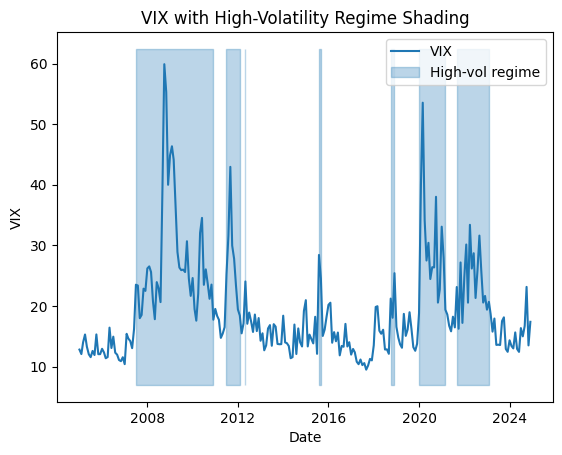

In [94]:
# Extract VIX series from macro data
vix = macro['vix']

# Fit a 2-state Markov switching model on VIX time series
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of high-volatility regime
#    (Assume regime 1 corresponds to high volatility)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]


# Plot VIX and overlay shading for high-volatility periods
fig, ax = plt.subplots()
x = vix.index

# Plot the VIX time series
line, = ax.plot(x, vix.values, label='VIX')

# Get vertical axis bounds for shading
ymin, ymax = ax.get_ylim()

# Shade regions where high-volatility regime probability > 0.35
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.35),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Set axis labels and plot title
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')

# Show legend
ax.legend(loc='upper right')

# Display plot
plt.show()

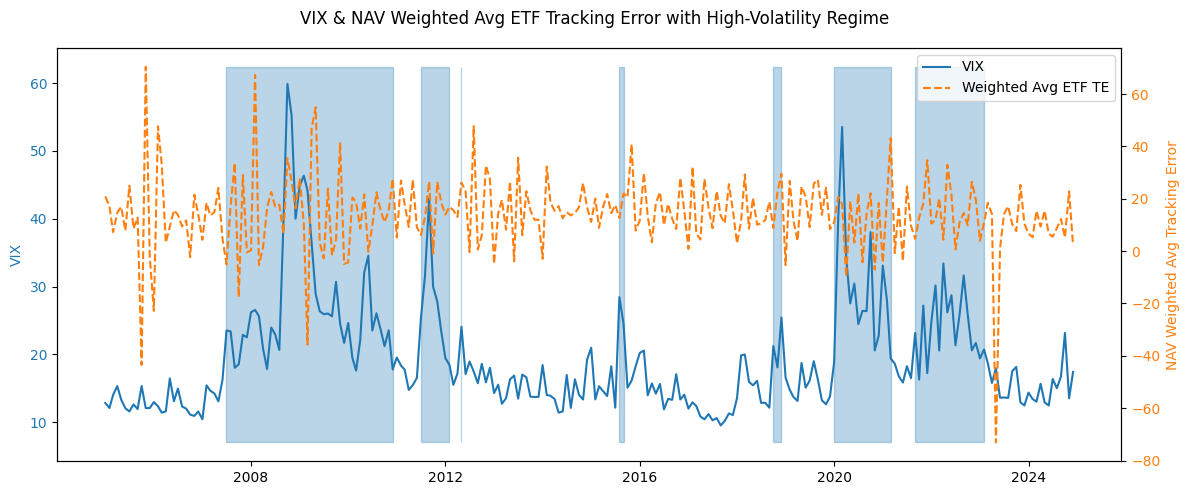

In [95]:
# Create a copy of the ETF data for weighted tracking error calculation
weighted_te = etf_data.copy()

# Drop rows with missing Tracking Error or Net Asset values
df_clean = weighted_te.dropna(subset=["Tracking_Error", "Net_Assets_USD"])

# Compute the NAV-weighted average tracking error for each date
weighted_te = (
    df_clean.groupby("Date")
            .apply(lambda g: np.average(g["Tracking_Error"], weights=g["Net_Assets_USD"]))
)

# Align weighted TE and VIX to a common time index
vix = macro['vix']
common_index = vix.index.intersection(weighted_te.index)
vix_aligned = vix.loc[common_index]
weighted_te_aligned = weighted_te.loc[common_index]

# Fit 2-regime Markov Switching model on VIX
ms_model = MarkovRegression(vix_aligned, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of being in high-volatility regime (assumed to be Regime 1)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]

# Plot: VIX and NAV-weighted average tracking error with regime shading
fig, ax1 = plt.subplots(figsize=(12, 5))

# VIX on primary y-axis
line1, = ax1.plot(vix_aligned.index, vix_aligned.values, label="VIX", color="C0")
ax1.set_ylabel("VIX", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

# Highlight high-volatility periods (probability > 0.35)
ymin, ymax = ax1.get_ylim()
ax1.fill_between(vix_aligned.index, ymin, ymax, where=(s > 0.35),
                 color="C0", alpha=0.3, label="High-vol regime")

# Weighted average TE on secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(weighted_te_aligned.index, weighted_te_aligned.values,
                  label="Weighted Avg ETF TE", linestyle="--", color="C1")
ax2.set_ylabel("NAV Weighted Avg Tracking Error", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")

# Title and combined legend
fig.suptitle("VIX & NAV Weighted Avg ETF Tracking Error with High-Volatility Regime")
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.tight_layout()
plt.show()

### VIX Series Standardisation

In [96]:
# Variance-stabilizing transformation using sqrt-log
vix_pre = np.sqrt(np.log1p(vix))

# Z-score standardisation
vix_std = (vix_pre - vix_pre.mean()) / vix_pre.std()

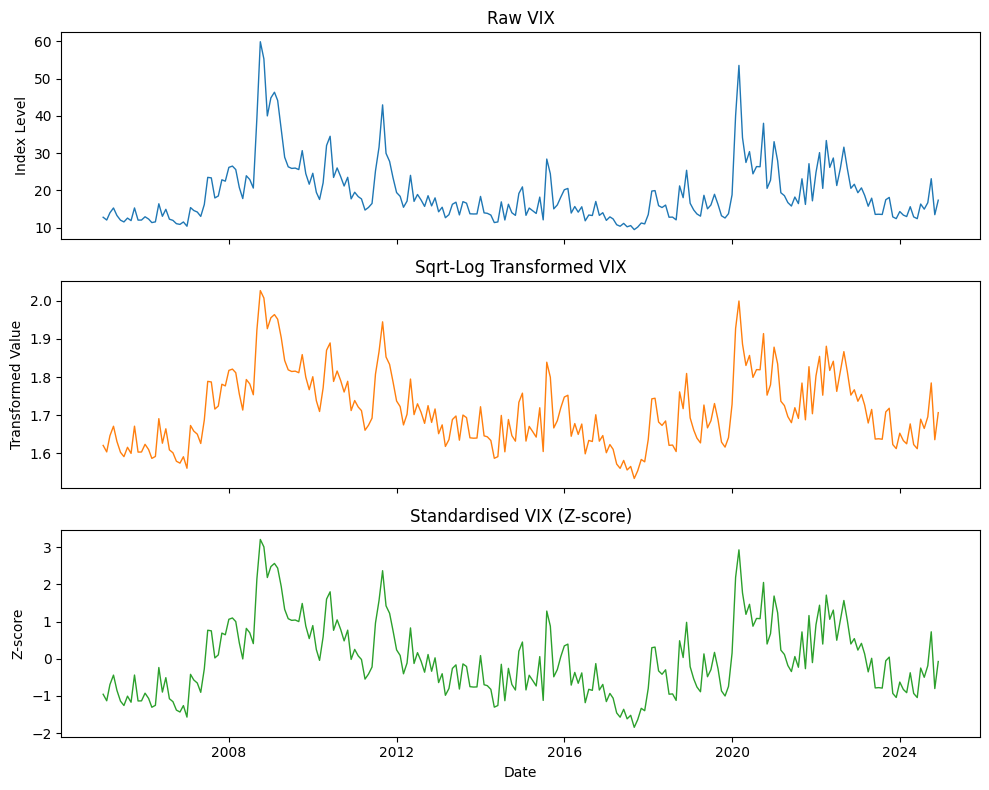

In [97]:
# Plot each series in its own vertical subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot 1 – Raw VIX
axes[0].plot(vix.index, vix, color='C0', lw=1)
axes[0].set_title("Raw VIX")
axes[0].set_ylabel("Index Level")

# Plot 2 – Variance-stabilized (sqrt-log)
axes[1].plot(vix_pre.index, vix_pre, color='C1', lw=1)
axes[1].set_title("Sqrt‑Log Transformed VIX")
axes[1].set_ylabel("Transformed Value")

# Plot 3 – Z-score standardised VIX
axes[2].plot(vix_std.index, vix_std, color='C2', lw=1)
axes[2].set_title("Standardised VIX (Z-score)")
axes[2].set_ylabel("Z-score")
axes[2].set_xlabel("Date")

# Adjust layout
plt.tight_layout()
plt.show()

### MS SARIMA (VIX Switch) Base Model

In [98]:
def fit_ms_sarima_vix(
    series: pd.Series,
    vix: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    regime_thresh: float = 0.5,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
    alpha: float = 0.05,
    min_obs: int = 15
) -> dict:
    """
    Fit a Markov-switching SARIMA(VIX) model using expanding-window CV. 
    Performs fold-specific VIX regime estimation and applies a shared Yeo-Johnson transform
    on the full training window to ensure regime forecasts remain on a common scale.

    Parameters
    ----------
    series : pd.Series
        The target time series (e.g., ETF tracking error).
    vix : pd.Series
        Exogenous VIX series used for regime switching.
    horizon : int
        Forecast horizon (number of steps ahead).
    cv_window : int
        Size of the expanding window used for training.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for outlier trimming before transformation.
    seasonal_period : int
        Periodicity for seasonal component (e.g. 12 for monthly).
    regime_thresh : float
        Fixed probability threshold to define high-vol regime.
    n_jobs : int
        Number of parallel jobs for cross-validation folds.
    arima_jobs : int
        Number of parallel jobs for `auto_arima`.
    max_pq : int
        Maximum AR and MA order for SARIMA.
    max_dD : int
        Maximum non-seasonal and seasonal differencing.
    forecast_plot : bool
        If True, plot the forecast with regime-aware CI at the final fold.
    alpha : float
        Significance level used in residual diagnostics.
    min_obs : int
        Minimum required observations per regime to model separately.

    Returns
    -------
    dict
        Dictionary with cross-validation metrics, residual diagnostics, and the forecast DataFrame.
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Prepare aligned time series and check fold feasibility
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()                         # Drop missing values from target
    v = vix.reindex_like(y).ffill()             # Align and forward-fill VIX
    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    # Define end indices for each expanding CV fold
    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # Helper: Estimate VIX regimes and transition probabilities
    # ─────────────────────────────────────────────────────────────
    def _regimes(v_sub):
        res = MarkovRegression(
            v_sub, k_regimes=2, trend="c",
            switching_variance=True,
            switching_trend=True
        ).fit(disp=False)
        p00, p10 = res.params["p[0->0]"], res.params["p[1->0]"]
        return (
            res.smoothed_marginal_probabilities.iloc[:, 1],  # P(high-vol regime)
            np.array([[p00, 1 - p00], [p10, 1 - p10]])        # Transition matrix
        )

    # ─────────────────────────────────────────────────────────────
    # Helper: Fit SARIMA model to transformed data
    # ─────────────────────────────────────────────────────────────
    def _sarima_fit_trans(ts_t):
        try:
            mod = auto_arima(
                ts_t, seasonal=True, m=seasonal_period, ic="aic",
                max_p=max_pq, max_q=max_pq, max_d=max_dD,
                max_P=max_pq, max_Q=max_pq, max_D=max_dD,
                stepwise=True, maxiter=20, suppress_warnings=True,
                error_action="ignore", n_jobs=arima_jobs
            )
        except ValueError:
            mod = auto_arima(
                ts_t, seasonal=False, ic="aic",
                max_p=max_pq, max_q=max_pq, max_d=max_dD,
                stepwise=True, maxiter=20, suppress_warnings=True,
                error_action="ignore", n_jobs=arima_jobs
            )
        return mod, mod.predict(horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-validation fold function
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        """
        Run one CV fold: split train/test, estimate regimes, fit SARIMA(s),
        forecast using mixture model based on regime probabilities.
        """
        # Split train/test
        y_tr, y_te = y.iloc[:end], y.iloc[end:end + horizon]
        v_tr = v.iloc[:end]

        # Regime flags
        prob, P = _regimes(v_tr)
        flag = prob > regime_thresh
        if flag.sum() < min_obs or (~flag).sum() < min_obs:
            flag[:] = False

        # Transform whole training window
        y_tr_t, tf_par = winsorize_yj(y_tr, winsor_limits)
        y_tr_t = pd.Series(y_tr_t, index=y_tr.index)

        # Fit SARIMA(s) and capture orders
        if flag.all() or (~flag).all():
            mod, fc_t = _sarima_fit_trans(y_tr_t)
            lo_mod = hi_mod = mod
            lo_fc = hi_fc = inv_yj(fc_t, tf_par)
        else:
            lo_mod, lo_fc_t = _sarima_fit_trans(y_tr_t[~flag])
            hi_mod, hi_fc_t = _sarima_fit_trans(y_tr_t[ flag])
            lo_fc = inv_yj(lo_fc_t, tf_par)
            hi_fc = inv_yj(hi_fc_t, tf_par)

        # Mixture forecast
        p_vec = np.array([1 - prob.iloc[-1], prob.iloc[-1]])
        fc_mix = []
        for h in range(horizon):
            p_vec = p_vec @ P
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])

        fc_df = pd.DataFrame({
            "Date": y_te.index,
            "Forecast": fc_mix,
            "Actual": y_te.values,
            "horizon": horizon
        })

        # Regime Diagnostics
        diag = {
            "n_hi": int(flag.sum()),
            "n_lo": int((~flag).sum()),
            "order_hi": str(hi_mod.order) if flag.any() else "na",
            "order_lo": str(lo_mod.order),
        }

        return (
            mean_absolute_error(y_te, fc_mix),
            mean_squared_error(y_te, fc_mix),
            r2_score(y_te, fc_mix),
            fc_df,
            diag
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Run CV folds in parallel and collect metrics
    # ─────────────────────────────────────────────────────────────
    res_list = Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends)
    mae, mse, r2, fc_dfs, diag_lst = zip(*res_list)

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": list(mae), "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": list(mse), "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": list(r2),  "mean": np.mean(r2),  "std": np.std(r2)},
        "tau": regime_thresh
    }
    forecast_df = pd.concat(fc_dfs, ignore_index=True)

    diag_df = pd.DataFrame(diag_lst)
    diag_df["Fold"] = np.arange(1, len(diag_df) + 1)

    # ─────────────────────────────────────────────────────────────
    # 3. Residual diagnostics on full training sample
    # ─────────────────────────────────────────────────────────────
    prob_full, P_full = _regimes(v)
    tr_y, te_y = y.iloc[:-horizon], y.iloc[-horizon:]
    tr_y_t, tf_par_tr = winsorize_yj(tr_y, winsor_limits)
    tr_y_t = pd.Series(tr_y_t, index=tr_y.index)
    flag_f = prob_full.iloc[:-horizon] > regime_thresh

    # Fit full-sample regime-specific SARIMA(s)
    if flag_f.all() or (~flag_f).all():
        lo_mod, lo_fc_t = _sarima_fit_trans(tr_y_t)
        hi_mod, hi_fc_t = lo_mod, lo_fc_t
    else:
        lo_mod, lo_fc_t = _sarima_fit_trans(tr_y_t[~flag_f])
        hi_mod, hi_fc_t = _sarima_fit_trans(tr_y_t[ flag_f])

    # Compute residuals and test for serial correlation, normality, ARCH effects
    lo_fit = inv_yj(lo_mod.predict_in_sample(), tf_par_tr)
    hi_fit = inv_yj(hi_mod.predict_in_sample(), tf_par_tr)
    fitted = pd.Series(index=tr_y.index, dtype=float)
    fitted.loc[~flag_f] = lo_fit
    fitted.loc[ flag_f] = hi_fit
    resid = tr_y - fitted

    lb_stat, lb_p = acorr_ljungbox(resid, lags=[10], return_df=True).iloc[0]
    jb_stat, jb_p = jarque_bera(resid)[:2]
    arch_stat, arch_p, *_ = het_arch(resid, nlags=10)

    residual_tests = {
        "Serial_LB(Q10)": {"stat": lb_stat, "p": lb_p,
                           "Result": "Fail" if lb_p < alpha else "Pass"},
        "Normality_JB":   {"stat": jb_stat, "p": jb_p,
                           "Result": "Fail" if jb_p < alpha else "Pass"},
        "ARCH_LM(10)":    {"stat": arch_stat, "p": arch_p,
                           "Result": "Fail" if arch_p < alpha else "Pass"},
    }

    # ─────────────────────────────────────────────────────────────
    # 4. Plot final fold forecast and GARCH-based CI (optional)
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        def _sigma(mod, sub_series):
            resid_s = pd.Series(mod.arima_res_.resid,
                                index=sub_series.index[-len(mod.arima_res_.resid):])
            z = resid_s / resid_s.std()
            gfit = arch_model(z, vol="Garch", p=1, q=1,
                              dist="t", rescale=False).fit(disp="off")
            var_h = gfit.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
            return np.sqrt(var_h) * resid_s.std()

        lo_fc = inv_yj(lo_fc_t, tf_par_tr)
        hi_fc = inv_yj(hi_fc_t, tf_par_tr)

        sig_lo = _sigma(lo_mod, tr_y.loc[~flag_f] if (~flag_f).any() else tr_y)
        sig_hi = _sigma(hi_mod, tr_y.loc[ flag_f] if  flag_f.any()  else tr_y)

        p_vec = np.array([1 - prob_full.iloc[-1], prob_full.iloc[-1]])
        fc_mix, sigma_mix = [], []
        for h in range(horizon):
            p_vec = p_vec @ P_full
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])
            sigma_mix.append(np.sqrt(p_vec[0] * sig_lo[h]**2 + p_vec[1] * sig_hi[h]**2))

        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev], te_y.values],
                 "-o", color="C0", label="Actual")
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev].values, fc_mix],
                 "--o", color="C1", label="Forecast")
        plt.errorbar(te_y.index, fc_mix,
                     yerr=1.96 * np.array(sigma_mix),
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")

        shade = pd.concat([prob_full.iloc[-prev_n:],
                           pd.Series([p_vec[1]] * horizon, index=te_y.index)])
        ymin, ymax = plt.ylim()
        plt.fill_between(shade.index, ymin, ymax, where=shade > regime_thresh,
                         color="C2", alpha=0.3, label="High‑Vol Regime")

        plt.title(f"Final CV Fold: MS‑SARIMA (h={horizon})  τ={regime_thresh:.2f}")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 5. Return metrics, diagnostics, and forecasts
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "residual_tests": residual_tests,
        "forecast_df": forecast_df,
        "regime_diag": diag_df
    }

### MS SARIMA (VIX Switch) Panel Fit

In [99]:
def run_ms_vix_panel(
    panel_df: pd.DataFrame,
    vix_series: pd.Series,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    date_col="Date",
    horizon=3, 
    cv_window=60, 
    cv_step=30,
    winsor_limits=(0.01, 0.01),
    seasonal_period=12,
    regime_thresh=0.5,
    n_jobs=-1, 
    arima_jobs=1, 
    max_pq=5, 
    max_dD=3,
    alpha=0.05, 
    plot_ticker=None
):
    """
    Fit MS-SARIMA(VIX) model across all ETFs in panel using parallel cross-validation.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Panel of ETF tracking error data with columns for tickers and dates.
    vix_series : pd.Series
        VIX time series to drive Markov-switching regimes.
    target_col : str
        Column name for the target variable (default "Tracking_Error").
    ticker_col : str
        Column name for ETF identifier (default "ETF_Ticker").
    date_col : str
        Column name for date (default "Date").
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial window size for expanding-window cross-validation.
    cv_step : int
        Step size between folds.
    winsor_limits : tuple
        Limits for winsorization before transformation.
    seasonal_period : int
        Seasonal period for SARIMA (e.g. 12 for monthly).
    regime_thresh : float
        Threshold for regime classification from VIX probabilities.
    n_jobs : int
        Number of parallel jobs for panel-level processing.
    arima_jobs : int
        Number of jobs for `auto_arima` fitting.
    max_pq : int
        Max AR and MA orders for SARIMA.
    max_dD : int
        Max differencing and seasonal differencing orders.
    alpha : float
        Significance level for residual diagnostics.
    plot_ticker : str or None
        ETF ticker to plot forecast for (final fold only).

    Returns
    -------
    Tuple of:
        - ms_vix_cv_fold_df        : Per-fold CV metrics averaged across ETFs
        - ms_vix_cv_summary_df     : Global summary (mean/std of each metric)
        - ms_vix_per_etf_df        : Per-ETF mean/std metrics
        - ms_vix_resid_diag_df     : Residual test stats and pass/fail counts
        - ms_vix_forecast_df       : All fold-level forecasts across ETFs
    """
    
    # ─────────────────────────────────────────────────────────────
    # Helper: run one ETF through fit_ms_sarima_vix
    # ─────────────────────────────────────────────────────────────
    def _run_one(etf):
        ser = (panel_df.loc[panel_df[ticker_col] == etf]
                          .sort_values(date_col)[target_col])
        res = fit_ms_sarima_vix(
            ser, vix_series,
            horizon, cv_window, cv_step, winsor_limits,
            seasonal_period, regime_thresh,
            n_jobs=1, arima_jobs=arima_jobs,
            max_pq=max_pq, max_dD=max_dD,
            forecast_plot=(etf == plot_ticker), alpha=alpha
        )
        fc   = res["forecast_df"].copy()
        fc["ETF"] = etf
        diag = res["regime_diag"].copy()
        diag["ETF"] = etf
        return etf, res["cv_metrics"], res["residual_tests"], fc, diag

    # Run all ETFs in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(_run_one)(etf) for etf in panel_df[ticker_col].unique()
    )

    # ─────────────────────────────────────────────────────────────
    # 1. Build per‑ETF performance table
    # ─────────────────────────────────────────────────────────────
    per_rows   = []
    resid_rows = {"Serial_LB(Q10)": [], "Normality_JB": [], "ARCH_LM(10)": []}

    for etf, cv, resid_diag, _, _ in results:
        per_rows.append([
            etf,
            cv["MAE"]["mean"], cv["MAE"]["std"],
            cv["MSE"]["mean"], cv["MSE"]["std"],
            cv["R2"]["mean"]
        ])
        for k in resid_rows:
            resid_rows[k].append(resid_diag[k])

    ms_vix_per_etf_df = (
        pd.DataFrame(
            per_rows,
            columns=["ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
        )
        .set_index("ETF")
        .sort_index()
    )

    # ─────────────────────────────────────────────────────────────
    # 2. Aggregate residual diagnostics across ETFs
    # ─────────────────────────────────────────────────────────────
    diag_rows = []
    for k, lst in resid_rows.items():
        stat_mean = np.mean([d["stat"] for d in lst])
        p_mean    = np.mean([d["p"] for d in lst])
        fails     = sum(d["Result"] == "Fail" for d in lst)
        passes    = len(lst) - fails
        diag_rows.append([k, stat_mean, p_mean, fails, passes])

    ms_vix_resid_diag_df = (
        pd.DataFrame(
            diag_rows,
            columns=["Test", "stat_mean", "p_mean",
                     "Fail_count", "Pass_count"]
        )
        .set_index("Test")
    )

    # ─────────────────────────────────────────────────────────────
    # 3. Per‑fold averages across ETFs
    # ─────────────────────────────────────────────────────────────
    n_folds   = results[0][1]["folds"]
    fold_rows = []
    for f in range(n_folds):
        mae_vals = [cv["MAE"]["values"][f] for _, cv, _, _, _ in results]
        mse_vals = [cv["MSE"]["values"][f] for _, cv, _, _, _ in results]
        r2_vals  = [cv["R2"]["values"][f]  for _, cv, _, _, _ in results]
        fold_rows.append([
            f + 1,
            np.mean(mae_vals), np.std(mae_vals),
            np.mean(mse_vals), np.std(mse_vals),
            np.mean(r2_vals)
        ])

    ms_vix_cv_fold_df = pd.DataFrame(
        fold_rows,
        columns=["Fold", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
    )

    # ─────────────────────────────────────────────────────────────
    # 4. Global summary
    # ─────────────────────────────────────────────────────────────
    ms_vix_cv_summary_df = (
        pd.DataFrame({
            "Metric": ["MAE", "MSE", "R2"],
            "Mean": [
                ms_vix_cv_fold_df["MAE"].mean(),
                ms_vix_cv_fold_df["MSE"].mean(),
                ms_vix_cv_fold_df["R2"].mean()
            ],
            "Std": [
                ms_vix_cv_fold_df["MAE"].std(),
                ms_vix_cv_fold_df["MSE"].std(),
                ms_vix_cv_fold_df["R2"].std()
            ]
        })
        .set_index("Metric")
    )

    # ─────────────────────────────────────────────────────────────
    # 5. Combine forecasts and regime diagnostics
    # ─────────────────────────────────────────────────────────────
    ms_vix_forecast_df     = pd.concat([fc   for *_, fc, _   in results],
                                       ignore_index=True)
    ms_vix_regime_diag_df  = pd.concat([diag for *_, diag in results],
                                       ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 6. Return everything
    # ─────────────────────────────────────────────────────────────
    return (
        ms_vix_cv_fold_df,
        ms_vix_cv_summary_df,
        ms_vix_per_etf_df,
        ms_vix_resid_diag_df,
        ms_vix_forecast_df,
        ms_vix_regime_diag_df
    )

### MS SARIMA (VIX Switch) Panel Results

In [100]:
# Run the Markov-Switching SARIMA–GARCH Model on VIX
(ms_vix_cv_fold_df,
 ms_vix_cv_summary_df,
 ms_vix_per_etf_df,
 ms_vix_resid_diag_df,
 ms_vix_forecast_df,
 ms_vix_regime_diag_df) = run_ms_vix_panel(
    etf_data, 
    vix_series=vix_std,
    horizon=3, 
    cv_window=cv_window, 
    cv_step=cv_step,
    n_jobs=-1, 
    regime_thresh=0.5,
)

In [101]:
# Display the results
print("\n=== MS-VIX: CV fold means across ETFs ===")
display(ms_vix_cv_fold_df.style.format("{:.6f}"))

print("\n=== MS-VIX: overall mean ± std ===")
display(ms_vix_cv_summary_df.style.format("{:.6f}"))

print("\n=== MS-VIX: per-ETF metrics ===")
display(ms_vix_per_etf_df.style.format("{:.6f}"))

print("\n=== MS-VIX: aggregate residual diagnostics ===")
display(ms_vix_resid_diag_df.style.format("{:.4f}"))

print("\n=== MS-VIX: per-fold regime diagnostics ===")
display(ms_vix_regime_diag_df[['ETF','Fold','n_hi','n_lo','order_hi','order_lo']])
ms_vix_regime_diag_df.to_excel("ms_vix_regime_diagnostics.xlsx", index=False)


=== MS-VIX: CV fold means across ETFs ===


,Fold,MAE,MAE_std,MSE,MSE_std,R2
0,1.000000,35.531522,72.200568,13888.419878,63042.170934,-1.141832
1,2.000000,29.691758,23.490866,1722.895792,2325.371178,-0.126210
2,3.000000,16.124792,22.796090,963.852505,2534.325448,-6.531177
3,4.000000,13.061927,19.204584,597.898275,2183.034017,-0.920233
4,5.000000,30.465022,75.604376,8756.955393,43907.092228,-1.268248
5,6.000000,21.742674,42.587424,3068.052298,9647.496834,-2.102003
6,7.000000,31.479526,49.832229,4256.791093,12390.408899,-0.454879



=== MS-VIX: overall mean ± std ===


,Mean,Std
Metric,,
MAE,25.442460,8.517658
MSE,4750.695033,4888.367665
R2,-1.792083,2.182341



=== MS-VIX: per-ETF metrics ===


,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,10.072197,4.667775,170.651764,153.276474,0.219168
IDU,61.939959,25.713433,6666.343176,5602.260753,-0.686834
IJH,5.581403,2.057195,40.032642,25.228976,-0.301125
IJR,9.730353,7.019699,167.611170,209.378698,-0.274567
IVV,9.680831,7.390213,175.999399,221.725574,-0.678616
IWB,8.976699,3.535780,105.916501,80.543897,-0.660303
IWD,12.585210,6.883355,282.182863,288.942370,-1.652004
IWF,13.819207,14.188525,469.801236,879.668525,-2.240160
IWM,10.978783,7.951149,242.915825,346.494374,-0.783308



=== MS-VIX: aggregate residual diagnostics ===


,stat_mean,p_mean,Fail_count,Pass_count
Test,,,,
Serial_LB(Q10),24.1453,0.1444,18.0000,12.0000
Normality_JB,1759.4567,0.0000,30.0000,0.0000
ARCH_LM(10),44.9568,0.0854,27.0000,3.0000



=== MS-VIX: per-fold regime diagnostics ===


,ETF,Fold,n_hi,n_lo,order_hi,order_lo
0,SPY,1,30,30,"(0, 0, 1)","(0, 0, 1)"
1,SPY,2,61,29,"(2, 0, 2)","(2, 0, 0)"
2,SPY,3,62,58,"(0, 0, 1)","(0, 0, 1)"
3,SPY,4,69,81,"(2, 0, 0)","(0, 0, 1)"
4,SPY,5,70,110,"(2, 0, 2)","(0, 0, 1)"
...,...,...,...,...,...,...
205,IYG,3,62,58,"(0, 0, 0)","(0, 0, 0)"
206,IYG,4,69,81,"(0, 0, 0)","(0, 0, 0)"
207,IYG,5,70,110,"(0, 0, 0)","(0, 0, 0)"
208,IYG,6,94,116,"(0, 0, 0)","(0, 0, 0)"


All three residual diagnostics fail (p < 0.05), indicating the MS-VIX-SARIMA + GARCH model has not purged all predictable structure.

Ljung-Box Q(10) detects short-run autocorrelation; Jarque-Bera flags heavy-tailed, non-Gaussian errors; ARCH-LM(10) reveals remaining volatility clustering.

These results point to remaining non-linear and interaction effects—e.g., asymmetric responses to VIX spikes, ETF-specific frictions—that classical linear/regime models cannot express.

# Gradient Boosted Decision Tree Model Fitting

### Helper Functions

In [102]:
def make_features(df, target="Tracking_Error", lags=(1, 2, 3)):
    """
    Generate lagged numeric features and integer-coded categorical variables from ETF dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing time series and static features for multiple ETFs.
    target : str
        Name of the target column to predict (default is "Tracking_Error").
    lags : tuple of int
        Lag values to create for all numeric columns.

    Returns
    -------
    X : pd.DataFrame
        Feature matrix including lagged variables and integer-encoded categorical variables.
    y : pd.Series
        Target variable aligned with X.
    df : pd.DataFrame
        Cleaned and augmented full DataFrame (with ETF_Ticker, Date, etc.).
    """
    df = df.copy()

    # Ensure presence of a "Date" column
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise KeyError("Need a Date column or datetime index.")

    # Sort to ensure correct lagging
    df = df.sort_values(["ETF_Ticker", "Date"])

    # Add lagged versions of all numeric columns
    num_cols = df.select_dtypes(include="number").columns.tolist()
    for col in num_cols:
        for l in lags:
            df[f"{col}_lag{l}"] = df.groupby("ETF_Ticker")[col].shift(l)

    # Preserve string ticker, but add an integer code
    df["ETF_code"] = pd.Categorical(df["ETF_Ticker"]).codes.astype("int32")

    # Convert all other categorical columns to integer codes
    cat_cols = [c for c in df.columns if c not in num_cols + ["Date", "ETF_Ticker", "ETF_code"]]
    for col in cat_cols:
        df[col] = pd.Categorical(df[col]).codes.astype("int32")

    # Drop columns with only one unique value and rows with missing values
    nunq = df.nunique(dropna=True)
    df = df.drop(columns=nunq[nunq <= 1].index).dropna()

    # Split features and target
    X = df.drop(columns=[target, "Date", "ETF_Ticker"])  # Keep ETF_code
    y = df[target]
    return X, y, df

In [103]:
def report_cv(cv):
    """
    Display cross-validation fold results and print mean ± std for each metric.

    Parameters
    ----------
    cv : dict
        Dictionary containing keys: 'folds', and nested metrics (MAE, MSE, R2),
        each with 'values', 'mean', and 'std'.
    """
    print("\n=== Cross-Validation Results ===")
    
    # Display table of metrics for each fold
    cv_df = pd.DataFrame({
        "Fold": range(1, cv["folds"] + 1),
        "MAE":  cv["MAE"]["values"],
        "MSE":  cv["MSE"]["values"],
        "R2":   cv["R2"]["values"],
    })
    display(cv_df.style.format("{:.6f}"))

    # Print mean ± std for each metric
    for k in ["MAE", "MSE", "R2"]:
        print(f"{k} mean ± std : {cv[k]['mean']:.6f} ± {cv[k]['std']:.6f}")

### XGBoost Model Fit

In [104]:
def fit_xgboost(
    df: pd.DataFrame,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    xgb_params: dict | None = None,
    forecast_plot: bool = True,
    plot_ticker: str | None = None,
    top_n_importance: int = 20,
):
    """
    Fit an expanding-window XGBoost model to forecast ETF tracking error.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format DataFrame with Date, ETF_Ticker, Tracking_Error, and predictors.
    horizon : int, default=3
        Forecast horizon in time steps.
    cv_window : int, default=60
        Minimum number of observations to start cross-validation.
    cv_step : int, default=30
        Step size for each expanding fold.
    xgb_params : dict or None, default=None
        Optional dictionary of XGBoost hyperparameters to override defaults.
    forecast_plot : bool, default=True
        If True, plots forecast vs actual for final fold.
    plot_ticker : str or None, default=None
        ETF ticker to use for final forecast plot (random if None).
    top_n_importance : int, default=20
        Number of top features to display in importance and SHAP plots.

    Returns
    -------
    dict
        Dictionary with CV metrics, per-ETF errors, feature importance,
        SHAP values, learning curve, and per-fold forecasts.
    """
    
    # ─────────────────────────────────────────────────────────────
    # 1. Preprocessing: feature engineering and indexing
    # ─────────────────────────────────────────────────────────────
    X_full, y_full, full = make_features(df)
    dates = np.sort(full["Date"].unique())

    # ─────────────────────────────────────────────────────────────
    # 2. Expanding-Window CV Fold Ends
    # ─────────────────────────────────────────────────────────────
    fold_ends = list(range(cv_window, len(dates) - horizon + 1, cv_step))
    if fold_ends[-1] != len(dates) - horizon:
        fold_ends.append(len(dates) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 3. Hyperparameter Setup
    # ─────────────────────────────────────────────────────────────
    params = dict(
        objective="reg:squarederror", n_estimators=600, learning_rate=0.05,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        tree_method="hist", enable_categorical=True, n_jobs=-1,
        random_state=0, eval_metric=["rmse"]
    )
    if xgb_params:
        params.update(xgb_params)

    mae_vals, mse_vals, r2_vals, fc_rows = [], [], [], []

    # ─────────────────────────────────────────────────────────────
    # 4. Expanding-Window CV Loop
    # ─────────────────────────────────────────────────────────────
    for pos in tqdm(fold_ends, desc="CV folds", unit="fold"):
        train_dates = dates[:pos+1]
        valid_dates = dates[pos+1:pos+1+horizon]

        tr_mask = full["Date"].isin(train_dates)
        va_mask = full["Date"].isin(valid_dates)

        model = XGBRegressor(**params).fit(
            X_full.loc[tr_mask], y_full.loc[tr_mask]
        )
        preds = model.predict(X_full.loc[va_mask])

        mae_vals.append(mean_absolute_error(y_full.loc[va_mask], preds))
        mse_vals.append(mean_squared_error(y_full.loc[va_mask], preds))
        r2_vals .append(r2_score        (y_full.loc[va_mask], preds))

        fc_rows.append(pd.DataFrame({
            "Date"      : full.loc[va_mask, "Date"].values,
            "ETF"       : full.loc[va_mask, "ETF_Ticker"].values,
            "horizon"   : horizon,
            "Forecast"  : preds,
            "Actual"    : y_full.loc[va_mask].values
        }))

    # ─────────────────────────────────────────────────────────────
    # 4b. Combine Per-Fold Forecasts
    # ─────────────────────────────────────────────────────────────
    forecast_df = pd.concat(fc_rows, ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 5. Final Model Fit (on last window)
    # ─────────────────────────────────────────────────────────────
    pos = fold_ends[-1]
    train_dates = dates[:pos+1]
    valid_dates = dates[pos+1:pos+1+horizon]

    tr_mask = full["Date"].isin(train_dates)
    va_mask = full["Date"].isin(valid_dates)

    final_model = XGBRegressor(**params).fit(
        X_full.loc[tr_mask], y_full.loc[tr_mask],
        eval_set=[(X_full.loc[tr_mask], y_full.loc[tr_mask]),
                  (X_full.loc[va_mask], y_full.loc[va_mask])],
        verbose=False
    )
    preds_final = final_model.predict(X_full.loc[va_mask])

    # ─────────────────────────────────────────────────────────────
    # 6. Global Feature Importance (Gain)
    # ─────────────────────────────────────────────────────────────
    imp_series = pd.Series(
        final_model.get_booster().get_score(importance_type="gain"),
        name="gain"
    ).sort_values(ascending=False)

    top_imp = imp_series.head(top_n_importance)
    plt.figure(figsize=(10, 0.35*len(top_imp)+1))
    top_imp[::-1].plot(kind="barh", color="C1")
    plt.title(f"Top {len(top_imp)} Features by Gain")
    plt.xlabel("Gain"); plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 7. SHAP Summary Plot
    # ─────────────────────────────────────────────────────────────
    sample_idx = np.random.choice(X_full.shape[0], size=min(5000, X_full.shape[0]), replace=False)
    shap_sample_X = X_full.iloc[sample_idx]
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(shap_sample_X)

    shap.summary_plot(
        shap_values, shap_sample_X,
        show=False, max_display=top_n_importance,
        plot_size=(10, 6)
    )
    plt.title("SHAP Value Summary Plot (Top Features)")
    plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 8. Final Fold: Per-ETF MAE, MSE, R² ± std
    # ─────────────────────────────────────────────────────────────
    rows = []
    valid_full = full.loc[va_mask].copy()
    valid_full["pred"] = preds_final

    for etf, g in valid_full.groupby("ETF_Ticker"):
        err = g["Tracking_Error"] - g["pred"]
        rows.append([
            etf,
            err.abs().mean(),  err.abs().std(ddof=0),
            (err**2).mean(),   (err**2).std(ddof=0),
            r2_score(g["Tracking_Error"], g["pred"]),
        ])

    per_df = pd.DataFrame(rows, columns=[
        "ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"
    ]).set_index("ETF").sort_index()

    display(per_df.style.format("{:.6f}"))

    # ─────────────────────────────────────────────────────────────
    # 9. Extract Learning Curve from Final Fit
    # ─────────────────────────────────────────────────────────────
    ev = final_model.evals_result_
    learning_curve = {
        "train_rmse": ev["validation_0"]["rmse"],
        "valid_rmse": ev["validation_1"]["rmse"],
    }

    # ─────────────────────────────────────────────────────────────
    # 10. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        ticker = plot_ticker or per_df.index[0]
        mask_ticker = full["ETF_Ticker"] == ticker

        act = full.loc[va_mask & mask_ticker, ["Date", "Tracking_Error"]].copy()
        act["Forecast"] = preds_final[mask_ticker[va_mask].values]

        hist = full.loc[tr_mask & mask_ticker, ["Date", "Tracking_Error"]].tail(10)

        plt.figure(figsize=(10, 4))
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Forecast"]]),
                 "--o", label="Forecast", color="C1", zorder=1)
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Tracking_Error"]]),
                 "-o", label="Actual", color="C0", zorder=2)
        plt.title(f"Final CV Fold: XGBoost Forecast ({horizon}-step)")
        plt.xlabel("Date"); plt.ylabel("Tracking Error"); plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 11. Return All Results in a Dictionary
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": {
            "folds": len(mae_vals),
            "MAE": {"values": mae_vals, "mean": np.mean(mae_vals), "std": np.std(mae_vals)},
            "MSE": {"values": mse_vals, "mean": np.mean(mse_vals), "std": np.std(mse_vals)},
            "R2":  {"values": r2_vals,  "mean": np.mean(r2_vals),  "std": np.std(r2_vals)},
        },
        "cv_fold_df": pd.DataFrame({
            "Fold": range(1, len(mae_vals)+1),
            "MAE":  mae_vals,
            "MSE":  mse_vals,
            "R2":   r2_vals
        }).set_index("Fold"),
        "feature_importance_df": imp_series,
        "per_etf_metrics": per_df,
        "learning_curve": learning_curve,
        "shap_values": shap_values,
        "shap_sample_X": shap_sample_X,
        "forecast_df": forecast_df            
    }

### XGBoost Results

CV folds: 100%|██████████| 7/7 [00:17<00:00,  2.50s/fold]


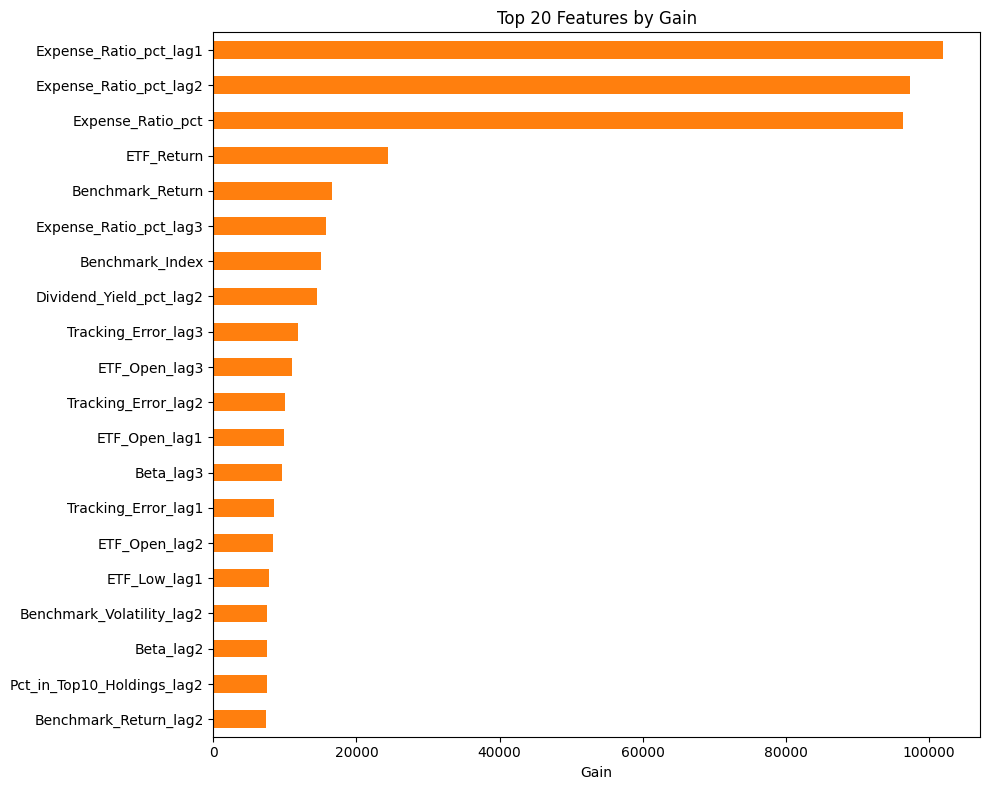

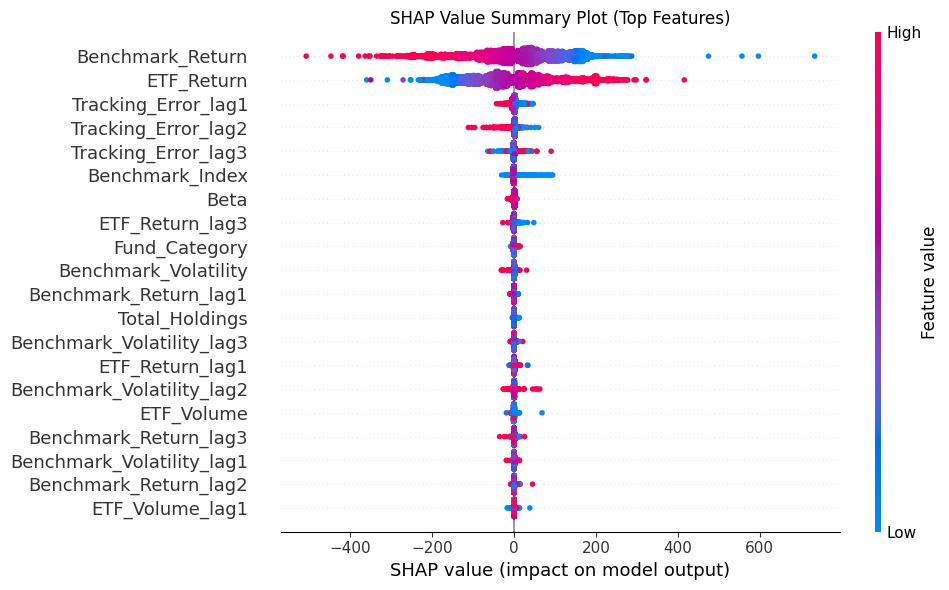

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,4.226044,3.028011,27.028295,25.593012,0.773548
IDU,26.735049,8.915706,794.252678,476.723676,-0.680504
IJH,9.332025,3.139205,96.941292,58.590272,0.133142
IJR,10.164324,4.739984,125.780924,96.357467,0.590925
IVV,1.025124,0.567087,1.372467,1.162669,0.943186
IWB,1.692960,0.747625,3.425057,2.531399,0.944419
IWD,4.438748,1.122129,20.961652,9.961691,0.767493
IWF,0.808760,0.091152,0.662402,0.147441,0.930849
IWM,4.873292,2.434576,29.676140,23.728803,0.762576


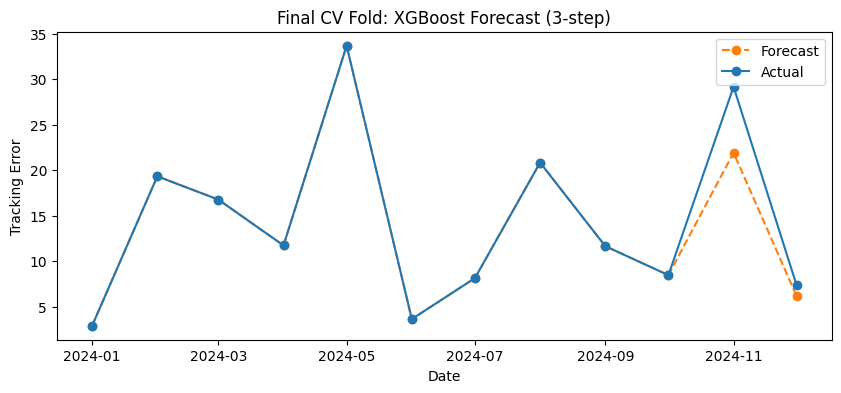

In [105]:
# Fit XGBoost model 
xgboost_results = fit_xgboost(
    etf_data,
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,22.162662,2002.268485,0.623339
1,2.000000,14.709351,552.267565,0.747348
2,3.000000,12.010433,498.595958,0.499200
3,4.000000,8.310080,258.294217,0.686860
4,5.000000,36.314133,5698.487005,-0.009495
5,6.000000,21.042717,2961.964749,0.527323
6,7.000000,11.735967,411.451728,0.857602


MAE mean ± std : 18.040763 ± 8.797870
MSE mean ± std : 1769.047101 ± 1856.955293
R2 mean ± std : 0.561740 ± 0.259901

=== Learning Curve ===


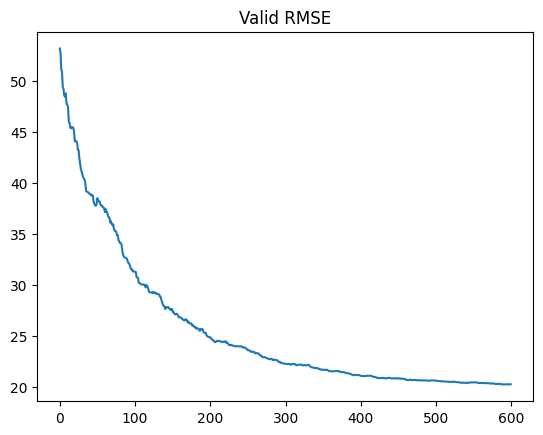

In [106]:
# Display cross-validation results
report_cv(xgboost_results["cv_metrics"])

# Display the learning curve
print("\n=== Learning Curve ===")
plt.plot(xgboost_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()

# MS-VIX-SARIMA Hybrid Model

### Hybrid Model Helper Functions

In [107]:
def _sarima_fit(ts, winsor_limits, m, max_pq, max_dD, arima_jobs):
    """
    Fit a SARIMA model to the transformed time series with seasonal fallback.

    Parameters
    ----------
    ts : pd.Series
        Raw time series to model.
    winsor_limits : tuple
        Lower and upper bounds for winsorization.
    m : int
        Seasonal period.
    max_pq : int
        Maximum AR and MA orders (p, q, P, Q).
    max_dD : int
        Maximum integration orders (d, D).
    arima_jobs : int
        Number of parallel jobs for auto_arima.

    Returns
    -------
    mod : pmdarima.ARIMA
        Fitted ARIMA model.
    tf_par : dict
        Transformation parameters (lambda, shift).
    """
    ts_t, tf_par = winsorize_yj(ts, winsor_limits)

    try:
        mod = auto_arima(ts_t, seasonal=True, m=m, ic="aic",
                         max_p=max_pq, max_q=max_pq, max_d=max_dD,
                         max_P=max_pq, max_Q=max_pq, max_D=max_dD,
                         stepwise=True, maxiter=50, suppress_warnings=True,
                         error_action="ignore", n_jobs=arima_jobs)
    except ValueError:
        mod = auto_arima(ts_t, seasonal=False, ic="aic",
                         max_p=max_pq, max_q=max_pq, max_d=max_dD,
                         stepwise=True, maxiter=50, suppress_warnings=True,
                         error_action="ignore", n_jobs=arima_jobs)

    return mod, tf_par

In [108]:
def _regimes(v_sub):
    """
    Fit a two-regime Markov Switching model to a volatility proxy (e.g. VIX).

    Parameters
    ----------
    v_sub : pd.Series
        Time series to model (typically a volatility index like VIX).

    Returns
    -------
    smoothed_prob : pd.Series
        Probability of being in the high-volatility regime at each time step.
    P : np.ndarray
        2×2 transition probability matrix between regimes.
    """
    # Fit two-regime Markov Switching model with constant mean and switching variance
    res = MarkovRegression(v_sub, k_regimes=2, trend="c",
                           switching_variance=True).fit(disp=False)

    # Extract transition probabilities
    p00 = res.params["p[0->0]"]  # Prob of staying in Regime 0
    p10 = res.params["p[1->0]"]  # Prob of switching from Regime 1 to Regime 0

    # Return smoothed prob of Regime 1 (typically high-vol) and transition matrix
    smoothed_prob = res.smoothed_marginal_probabilities.iloc[:, 1]
    P = np.array([[p00, 1 - p00], [p10, 1 - p10]])

    return smoothed_prob, P

In [109]:
def add_msvix_features(
    panel_df,
    vix_series,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    horizon: int = 3,
    cv_window: int = 60,
    winsor_limits=(0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    include_fc: bool = True,
    include_err: bool = True,
    include_params: bool = True,
    include_vix_prob: bool = True
):
    """
    Adds MSVIX-based features to a panel of ETF time series.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Multi-ETF panel with columns: [Date/index, ETF_Ticker, Tracking_Error].
    vix_series : pd.Series
        VIX (or other volatility index) aligned with time axis.
    target_col : str
        Column name for the target variable (default "Tracking_Error").
    ticker_col : str
        Column name identifying the ETF (default "ETF_Ticker").
    horizon : int
        Forecasting horizon (default 3).
    cv_window : int
        Size of the initial training window (default 60).
    winsor_limits : tuple
        Winsorization limits for Yeo-Johnson transform (default (0.01, 0.01)).
    seasonal_period : int
        Seasonality parameter `m` for SARIMA (default 12).
    n_jobs : int
        Number of parallel jobs (default -1).
    arima_jobs : int
        Number of parallel jobs for auto_arima (default 1).
    max_pq : int
        Maximum AR and MA order (default 5).
    max_dD : int
        Maximum differencing and seasonal differencing order (default 3).
    include_fc : bool
        Whether to add MSVIX_fc_h1/2/3 (default True).
    include_err : bool
        Whether to add MSVIX_err_h1/2/3 (default True).
    include_params : bool
        Whether to add SARIMA_p,d,q,P,D,Q,m (default True).
    include_vix_prob : bool
        Whether to add VIX_prob_high regime probability (default True).

    Returns
    -------
    panel_out : pd.DataFrame
        Original panel with MSVIX feature columns added.
    """

    # ─────────────────────────────────────────────────────────────
    # 1. Sort by date or index
    # ─────────────────────────────────────────────────────────────
    sorter = (lambda df: df.sort_values("Date")) \
             if "Date" in panel_df.columns else (lambda df: df.sort_index())

    def _one_etf(etf):
        sub = sorter(panel_df.loc[panel_df[ticker_col] == etf])
        y = sub[target_col].dropna()
        v = vix_series.reindex_like(y).ffill()
        idx = sub.index
        out = {}

        # ─── Prepare blank containers ─────────────────────────────
        fc_cols   = {f"MSVIX_fc_h{h}":  pd.Series(np.nan, index=idx) for h in (1, 2, 3)} if include_fc else {}
        err_cols  = {f"MSVIX_err_h{h}": pd.Series(np.nan, index=idx) for h in (1, 2, 3)} if include_err else {}
        param_cols = {} if include_params else {}

        if len(y) >= cv_window + horizon:
            # ─── 2. Initial fit on first window ──────────────────────
            train_end = cv_window
            mod, tf_par = _sarima_fit(
                y.iloc[:train_end],
                winsor_limits, seasonal_period, max_pq, max_dD, arima_jobs
            )

            # Record SARIMA orders
            if include_params:
                p, d, q = mod.order
                P, D, Q, m = mod.seasonal_order
                for name, val in {
                    "SARIMA_p": p, "SARIMA_d": d, "SARIMA_q": q,
                    "SARIMA_P": P, "SARIMA_D": D, "SARIMA_Q": Q, "SARIMA_m": m
                }.items():
                    param_cols[name] = pd.Series(val, index=idx, dtype=float)

            # ─── 3. In-sample forecast and error ────────────────────
            fc_in  = pd.Series(inv_yj(mod.predict_in_sample(), tf_par),
                               index=y.index[:train_end])
            err_in = y.iloc[:train_end] - fc_in

            if include_fc:
                for h in (1, 2, 3):
                    fc_cols[f"MSVIX_fc_h{h}"].loc[fc_in.index] = fc_in.values
            if include_err:
                for h in (1, 2, 3):
                    err_cols[f"MSVIX_err_h{h}"].loc[err_in.index] = err_in.values

            # ─── 4. Rolling forecast without refit ──────────────────
            for t in range(train_end, len(y)):
                fc = mod.predict(n_periods=horizon)
                if include_fc:
                    for h in range(1, horizon + 1):
                        tgt = y.index[t + h - 1] if t + h - 1 < len(y) else None
                        if tgt is not None:
                            fc_cols[f"MSVIX_fc_h{h}"].loc[tgt] = fc[h - 1]
                mod.update(y.iloc[t])

            # ─── 5. Compute rolling errors ──────────────────────────
            if include_err:
                for h in (1, 2, 3):
                    fc_ser = fc_cols[f"MSVIX_fc_h{h}"]
                    err_cols[f"MSVIX_err_h{h}"] = y - fc_ser

        # ─── 6. Final fill for all added series ───────────────────
        for d in (fc_cols, err_cols, param_cols):
            for k, s in d.items():
                out[k] = s.ffill().bfill()

        return out

    # ─────────────────────────────────────────────────────────────
    # 2. Run _one_etf across all ETFs in parallel
    # ─────────────────────────────────────────────────────────────
    etfs = panel_df[ticker_col].unique()
    dicts = Parallel(n_jobs=n_jobs)(
        delayed(_one_etf)(etf) for etf in etfs
    )

    # ─────────────────────────────────────────────────────────────
    # 3. Merge all feature dictionaries into panel
    # ─────────────────────────────────────────────────────────────
    panel_out = panel_df.copy()
    for d in dicts:
        for name, series in d.items():
            panel_out.loc[series.index, name] = series

    # ─────────────────────────────────────────────────────────────
    # 4. Optional: add VIX regime probabilities
    # ─────────────────────────────────────────────────────────────
    if include_vix_prob:
        vix = vix_series.sort_index().ffill()
        res = MarkovRegression(vix, k_regimes=2, trend="c",
                               switching_variance=True).fit(disp=False)
        prob = res.predicted_marginal_probabilities.iloc[:, 1]
        panel_out["VIX_prob_high"] = prob.reindex(panel_out.index).ffill().bfill()

    return panel_out

### Hybrid Model Results

In [110]:
# Build a dataset with MSVIX features
etf_data_enriched = add_msvix_features(
    etf_data,
    vix_series=vix_std,
    horizon=3,
    cv_window=cv_window,
    n_jobs=-1,
    include_fc=True, 
    include_err=False, 
    include_params=False, 
    include_vix_prob=True
)

CV folds: 100%|██████████| 7/7 [00:20<00:00,  2.86s/fold]


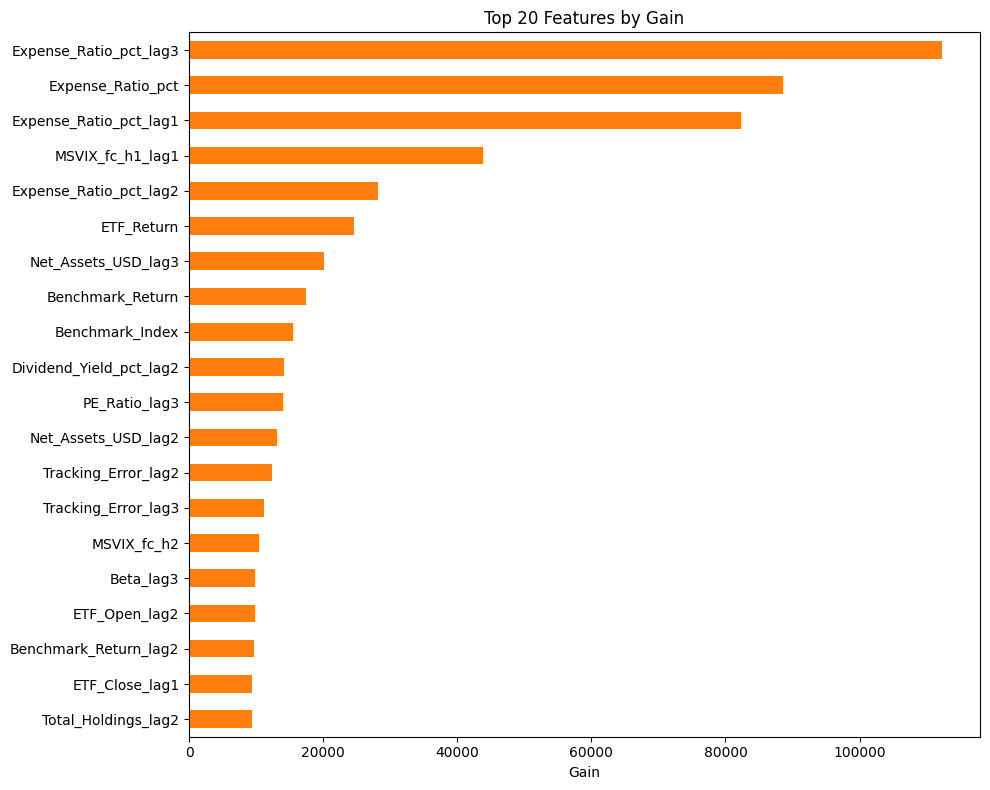

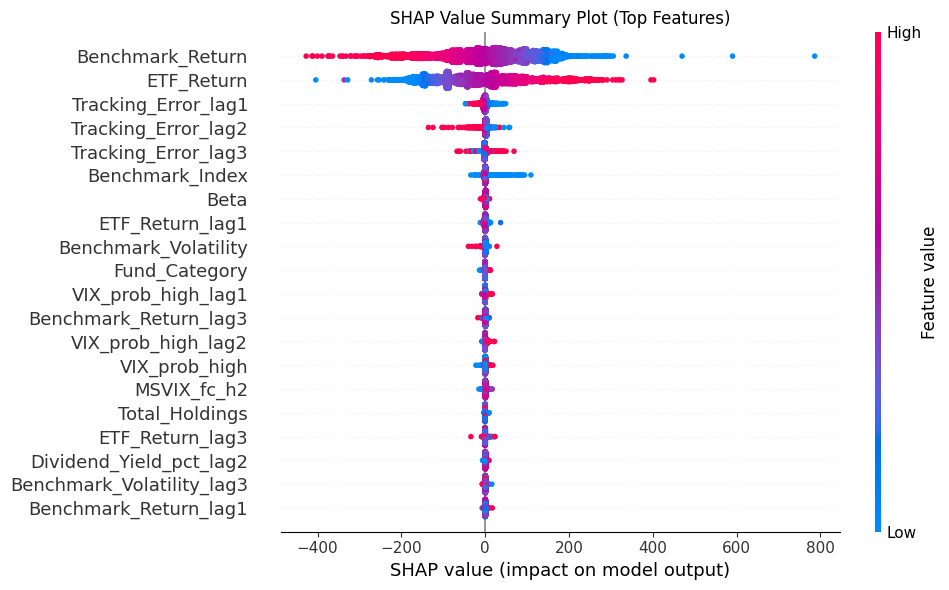

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,2.899630,1.974953,12.308296,11.453269,0.896877
IDU,21.183462,3.796943,463.155819,160.864780,0.020041
IJH,7.909278,3.703699,76.274064,58.587169,0.317950
IJR,10.912081,7.416519,174.078270,161.859321,0.433848
IVV,1.118506,0.659120,1.685494,1.474458,0.930228
IWB,0.655829,0.655822,0.860215,0.860215,0.986041
IWD,5.552921,3.976558,46.647947,44.163028,0.482581
IWF,0.603520,0.409620,0.532025,0.494427,0.944459
IWM,6.000552,4.128863,53.054126,49.550906,0.575541


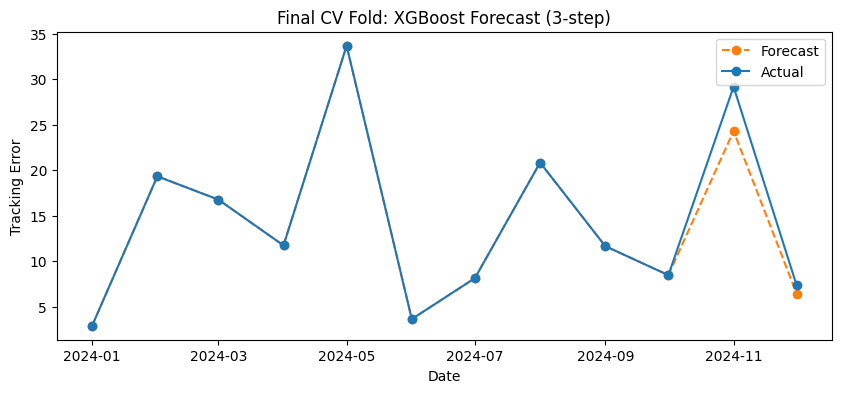

In [111]:
# Run XGBoost with dataset enhanced with MSVIX features
hybrid_results = fit_xgboost(
    etf_data_enriched,               
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,21.397493,2294.990803,0.568273
1,2.000000,15.757376,614.212210,0.719010
2,3.000000,10.675924,365.113675,0.633272
3,4.000000,8.544840,249.702793,0.697276
4,5.000000,28.296686,4953.998827,0.122392
5,6.000000,19.951729,2589.639962,0.586739
6,7.000000,9.770811,264.165464,0.908576


MAE mean ± std : 16.342123 ± 6.739278
MSE mean ± std : 1618.831962 ± 1639.412062
R2 mean ± std : 0.605077 ± 0.223307

=== Learning Curve ===


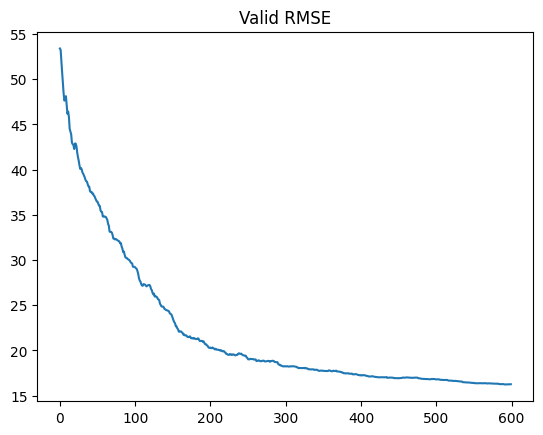

In [112]:
# Display cross-validation results
report_cv(hybrid_results["cv_metrics"])

# Display the learning curve
print("\n=== Learning Curve ===")
plt.plot(hybrid_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()

# SARIMA Hybrid Model

### SARIMA Hybrid Model Function

In [113]:
def add_sarima_features(
    panel_df: pd.DataFrame,
    *,
    target_col: str = "Tracking_Error",
    ticker_col: str = "ETF_Ticker",
    horizon: int = 3,
    cv_window: int = 60,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    include_fc: bool = True,
    include_err: bool = True,
    include_params: bool = True,
):
    """
    Add plain SARIMA‑based rolling‑window features (forecasts, errors, orders)
    for every ETF in `panel_df`.  Intended for use in a hybrid XGBoost model.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Long‑format panel with at least [Date, ETF_Ticker, Tracking_Error].
    target_col : str
        Name of the column to forecast (default "Tracking_Error").
    ticker_col : str
        Name of the ETF identifier column (default "ETF_Ticker").
    horizon : int
        Forecast horizon h (creates SARIMA_fc_h1 … h_h).
    cv_window : int
        Initial in‑sample window length before rolling forecasts begin.
    winsor_limits, seasonal_period, n_jobs, arima_jobs, max_pq, max_dD
        Passed straight to the `_sarima_fit` helper (same defaults
        as in your MS‑VIX feature routine).
    include_fc / include_err / include_params : bool
        Toggle whether to output forecasts, forecast errors, and ARIMA orders.

    Returns
    -------
    panel_out : pd.DataFrame
        Original `panel_df` plus new columns:
            SARIMA_fc_h1 … SARIMA_fc_h{horizon}
            SARIMA_err_h1 … SARIMA_err_h{horizon}
            SARIMA_p, SARIMA_d, SARIMA_q, SARIMA_P, SARIMA_D, SARIMA_Q, SARIMA_m
    """

    # ─────────────────────────────────────────────────────────────
    # 1. Sort by date to ensure correct lag / rolling logic
    # ─────────────────────────────────────────────────────────────
    sorter = (
        (lambda _df: _df.sort_values("Date"))
        if "Date" in panel_df.columns
        else (lambda _df: _df.sort_index())
    )

    # ─────────────────────────────────────────────────────────────
    # 2. Helper: process one ETF, return dict of Series
    # ─────────────────────────────────────────────────────────────
    def _one_etf(etf):
        sub = sorter(panel_df.loc[panel_df[ticker_col] == etf])
        y = sub[target_col].dropna()
        idx = sub.index                     

        # Empty dict for output Series
        out: dict[str, pd.Series] = {}

        # Pre‑allocate forecast / error containers (filled with NaN)
        fc_cols  = {
            f"SARIMA_fc_h{h}":  pd.Series(np.nan, index=idx)
            for h in range(1, horizon + 1)
        } if include_fc else {}
        err_cols = {
            f"SARIMA_err_h{h}": pd.Series(np.nan, index=idx)
            for h in range(1, horizon + 1)
        } if include_err else {}
        param_cols: dict[str, pd.Series] = {}

        # Skip ETFs that are shorter than the initial window + horizon
        if len(y) >= cv_window + horizon:
            # ── 2a. Initial SARIMA fit on first window ───────────────
            train_end = cv_window
            mod, tf_par = _sarima_fit(
                y.iloc[:train_end],
                winsor_limits, seasonal_period,
                max_pq, max_dD, arima_jobs
            )

            # Record SARIMA orders (static over time)
            if include_params:
                p, d, q = mod.order
                P, D, Q, m = mod.seasonal_order
                for nm, val in {
                    "SARIMA_p": p, "SARIMA_d": d, "SARIMA_q": q,
                    "SARIMA_P": P, "SARIMA_D": D, "SARIMA_Q": Q, "SARIMA_m": m
                }.items():
                    param_cols[nm] = pd.Series(val, index=idx, dtype=float)

            # ── 2b. In‑sample fitted values / errors for first window
            fc_in  = pd.Series(inv_yj(mod.predict_in_sample(), tf_par),
                               index=y.index[:train_end])
            err_in = y.iloc[:train_end] - fc_in

            if include_fc:
                for h in range(1, horizon + 1):
                    fc_cols[f"SARIMA_fc_h{h}"].loc[fc_in.index] = fc_in.values
            if include_err:
                for h in range(1, horizon + 1):
                    err_cols[f"SARIMA_err_h{h}"].loc[err_in.index] = err_in.values

            # ── 2c. Rolling one‑step update & multi‑h forecasts
            for t in range(train_end, len(y)):
                fc = mod.predict(n_periods=horizon)
                if include_fc:
                    for h in range(1, horizon + 1):
                        tgt = y.index[t + h - 1] if t + h - 1 < len(y) else None
                        if tgt is not None:
                            fc_cols[f"SARIMA_fc_h{h}"].loc[tgt] = fc[h - 1]
                mod.update(y.iloc[t])

            # ── 2d. Compute rolling forecast errors
            if include_err:
                for h in range(1, horizon + 1):
                    fc_ser = fc_cols[f"SARIMA_fc_h{h}"]
                    err_cols[f"SARIMA_err_h{h}"] = y - fc_ser

        # ── 2e. Final forward/backward fill to match original index
        for dct in (fc_cols, err_cols, param_cols):
            for name, series in dct.items():
                out[name] = series.ffill().bfill()

        return out

    # ─────────────────────────────────────────────────────────────
    # 3. Parallel processing across ETFs
    # ─────────────────────────────────────────────────────────────
    dicts = Parallel(n_jobs=n_jobs)(
        delayed(_one_etf)(etf) for etf in panel_df[ticker_col].unique()
    )

    # ─────────────────────────────────────────────────────────────
    # 4. Merge new feature columns back into panel
    # ─────────────────────────────────────────────────────────────
    panel_out = panel_df.copy()
    for d in dicts:
        for col_name, ser in d.items():
            panel_out.loc[ser.index, col_name] = ser

    return panel_out

### SARIMA Hybrid Model Results

In [114]:
# Build a dataset with SARIMA features
etf_data_sarima_enriched = add_sarima_features(
    panel_df     = etf_data,      
    target_col   = "Tracking_Error",
    ticker_col   = "ETF_Ticker",
    horizon      = 3,
    cv_window    = 60,
    winsor_limits=(0.01, 0.01),
    seasonal_period = 12,
    n_jobs       = -1,
    arima_jobs   = 2,            
    include_fc   = True,
    include_err  = False,
    include_params = False,
)

CV folds: 100%|██████████| 7/7 [00:19<00:00,  2.84s/fold]


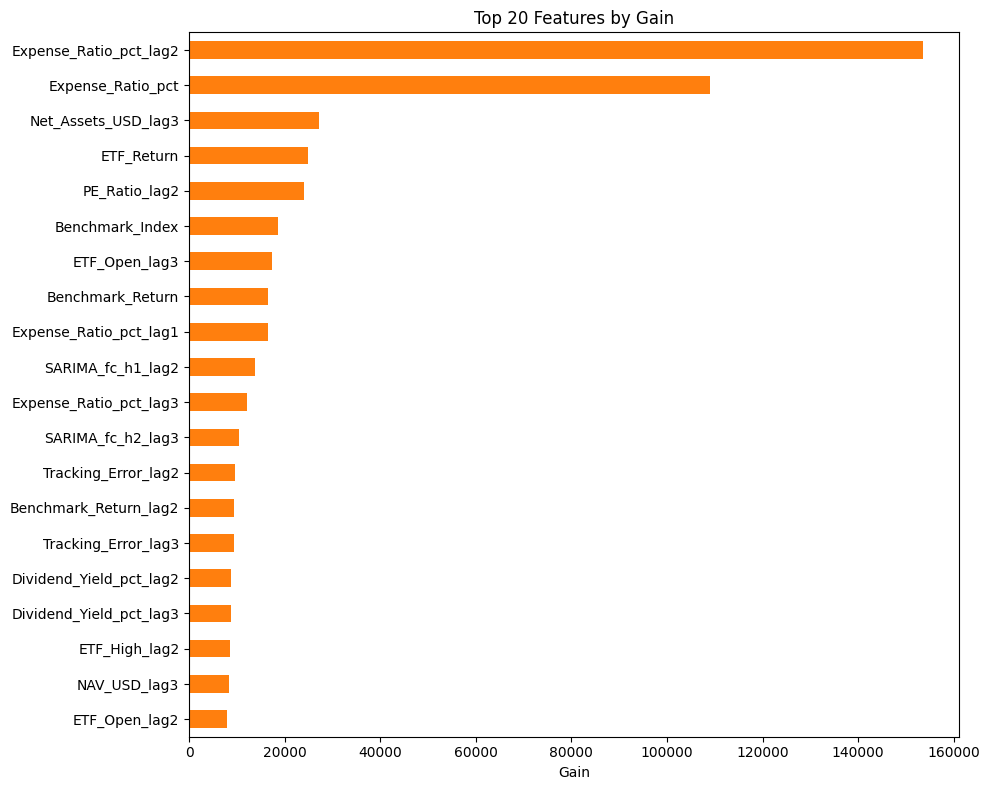

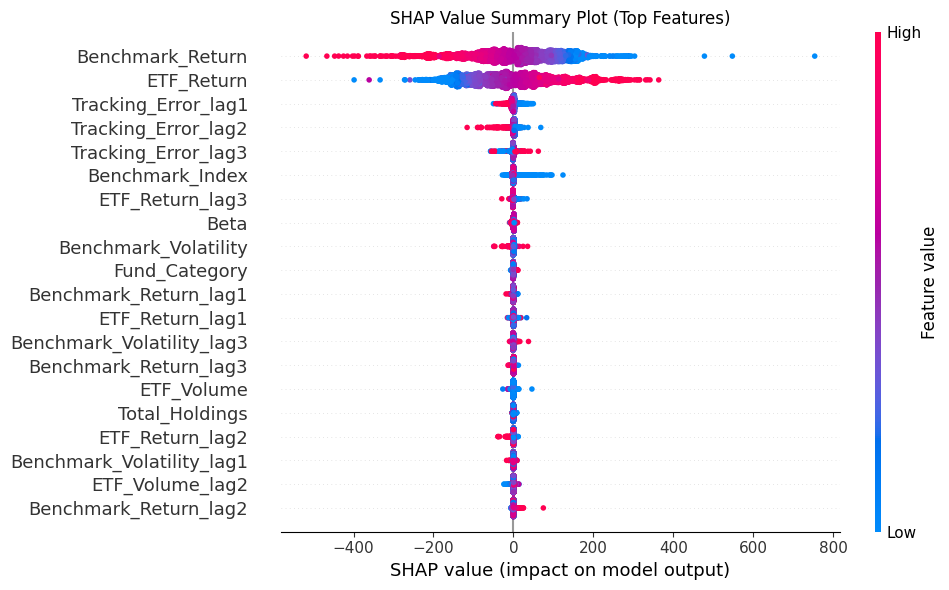

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,3.399785,2.985583,20.472243,20.300680,0.828477
IDU,19.390147,14.672954,591.273389,569.021474,-0.251034
IJH,7.728231,4.235523,77.665215,65.466208,0.305510
IJR,12.128299,5.256423,174.725606,127.502926,0.431743
IVV,1.190661,1.118071,2.667756,2.662487,0.889567
IWB,1.067072,0.705201,1.635950,1.504999,0.973452
IWD,3.725235,3.428384,25.631193,25.543073,0.715699
IWF,1.447051,1.238633,3.628168,3.584731,0.621238
IWM,4.460375,4.441764,39.624215,39.623869,0.682987


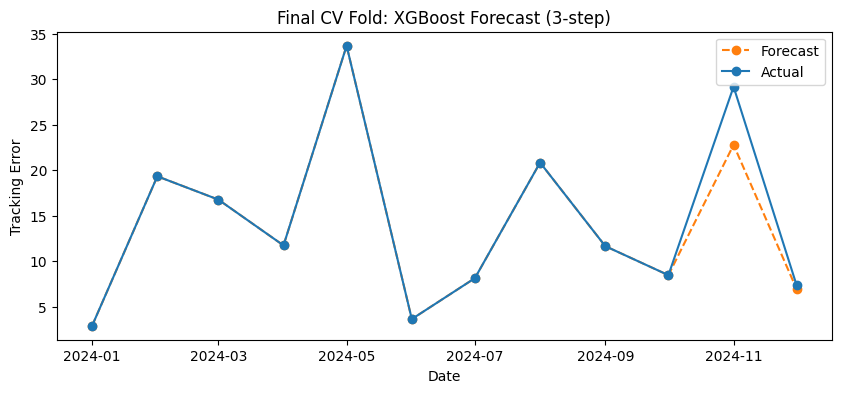

In [115]:
# Run XGBoost with dataset enhanced with SARIMA features
sarima_hybrid_results = fit_xgboost(
    etf_data_sarima_enriched,               
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,22.012698,2138.555849,0.597701
1,2.000000,14.924225,594.942199,0.727825
2,3.000000,10.920455,400.317534,0.597913
3,4.000000,9.291280,301.588650,0.634372
4,5.000000,30.107113,4869.225138,0.137410
5,6.000000,22.588384,2853.445305,0.544640
6,7.000000,12.010684,410.583109,0.857902


MAE mean ± std : 17.407834 ± 7.097048
MSE mean ± std : 1652.665398 ± 1607.106931
R2 mean ± std : 0.585395 ± 0.206883

=== Learning Curve ===


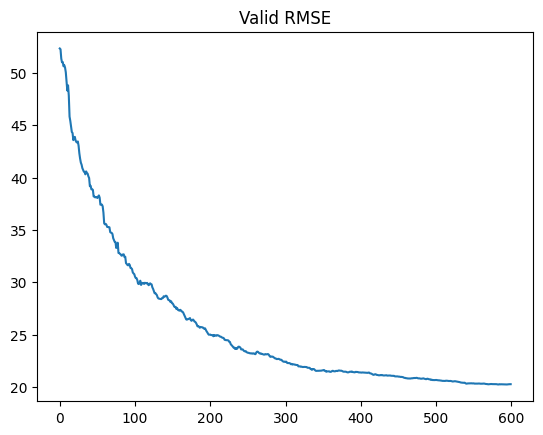

In [116]:
# Display cross-validation results
report_cv(sarima_hybrid_results["cv_metrics"])

# Display the learning curve
print("\n=== Learning Curve ===")
plt.plot(sarima_hybrid_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()

# Diebold-Mariano Test

### Helper Functions & Set-up

In [117]:
# Define order in which models will be displayed or compared
model_order = ["SARIMA_GARCH", "MS_VIX", "XGB", "SARIMA_HYBRID", "HYBRID_XGB"]

# Significance level for statistical tests 
alpha = 0.05                    

# Collect raw forecast DataFrames from each model
frames_raw = {
    "SARIMA_GARCH": sarima_garch_forecast_df,       # Baseline SARIMA-GARCH forecasts
    "MS_VIX"      : ms_vix_forecast_df,             # SARIMA with Markov-switching on VIX
    "XGB"         : xgboost_results["forecast_df"], # Pure XGBoost forecasts
    "SARIMA_HYBRID": sarima_hybrid_results["forecast_df"], # SARIMA features in XGBoost
    "HYBRID_XGB"  : hybrid_results["forecast_df"],   # XGBoost on MS-VIX residuals
}

In [118]:
# ─────────────────────────────────────────────────────────────
# 1. Diebold–Mariano Test (Works with MAE or RMSE/MSE)
# ─────────────────────────────────────────────────────────────
def dm_test(err_a, err_b, h: int, loss: str = "mae"):
    """
    Compute the Diebold–Mariano statistic for two forecast error series.

    Parameters
    ----------
    err_a : array-like
        Forecast errors from model A (e.g., actual - predicted).
    err_b : array-like
        Forecast errors from model B.
    h : int
        Forecast horizon.
    loss : str
        Loss function to compare errors ('mae' or 'rmse').

    Returns
    -------
    dm : float
        Diebold–Mariano test statistic.
    p_val : float
        Two-sided p-value.
    """
    loss = loss.lower()
    if loss == "mae":
        d = np.abs(err_a) - np.abs(err_b)
    elif loss in ("rmse", "mse"):
        d = err_a**2 - err_b**2
    else:
        raise ValueError("loss should be 'mae' or 'rmse'")

    # Compute Newey–West adjusted variance of loss differential
    T = len(d)
    d_bar = d.mean()
    q = h - 1
    gamma0 = np.mean((d - d_bar) ** 2)
    gamma = [np.mean((d[q:] - d_bar) * (d[:-q] - d_bar)) for q in range(1, q + 1)]
    var_d = gamma0 + 2 * np.sum(gamma)

    # Compute DM statistic and corresponding two-sided p-value
    dm = d_bar / np.sqrt(var_d / T)
    p_val = 2 * (1 - 0.5 * (1 + np.math.erf(abs(dm) / np.sqrt(2))))
    return dm, p_val


# ─────────────────────────────────────────────────────────────
# 2. Standardize Forecast DataFrame Column Names
# ─────────────────────────────────────────────────────────────
def _std(df):
    """
    Ensure consistent naming of ETF and extract only relevant columns.
    """
    df = df.copy()
    if "ETF" in df.columns and "ETF_Ticker" not in df.columns:
        df = df.rename(columns={"ETF": "ETF_Ticker"})
    return df[["Date", "ETF_Ticker", "horizon", "Forecast", "Actual"]]


# Apply column standardization to all model forecast DataFrames
model_frames = {m: _std(frames_raw[m]) for m in model_order}


# ─────────────────────────────────────────────────────────────
# 3. Compute Pooled Diebold–Mariano Tests Across All ETFs
# ─────────────────────────────────────────────────────────────
from itertools import combinations

def pooled_dm(loss):
    """
    Run pairwise DM tests across all models on merged forecasts.

    Parameters
    ----------
    loss : str
        Loss function to use ('mae' or 'rmse').

    Returns
    -------
    out : pd.DataFrame
        DataFrame of DM statistics, p-values, significance, and winner.
    """
    rows = []
    for (a, df_a), (b, df_b) in combinations(model_frames.items(), 2):
        # Merge forecast data for models A and B
        merged = (df_a.merge(df_b,
                             on=["Date", "ETF_Ticker", "horizon"],
                             suffixes=("_a", "_b")).dropna())

        # Compute error series for both models
        err_a = merged["Actual_a"] - merged["Forecast_a"]
        err_b = merged["Actual_a"] - merged["Forecast_b"]

        # Run DM test on errors
        dm, p = dm_test(err_a.values, err_b.values,
                        h=int(merged["horizon"].iloc[0]), loss=loss)
        rows.append([a, b, dm, p])

    # Organize results into DataFrame
    out = pd.DataFrame(rows, columns=["Model_A", "Model_B", "DM_stat", "p_value"])
    out["Sig?"] = out["p_value"] < alpha
    out["Winner"] = out.apply(
        lambda r: "Tie" if not r["Sig?"]
        else (r["Model_A"] if r["DM_stat"] < 0 else r["Model_B"]),
        axis=1
    )
    return out


# ─────────────────────────────────────────────────────────────
# 4. Construct Result Matrices From Pooled DM Output
# ─────────────────────────────────────────────────────────────
def matrices_from(pooled):
    """
    Generate three matrices:
    1. Significance + p-value,
    2. Raw MAE-based winner,
    3. DM-stat value with sign.

    Parameters
    ----------
    pooled : pd.DataFrame
        Pooled DM test output from `pooled_dm`.

    Returns
    -------
    g_sig : pd.DataFrame
        Matrix of significance labels (winner + p-value).
    g_raw : pd.DataFrame
        Matrix of raw MAE-based model winners.
    g_dm  : pd.DataFrame
        Matrix of DM-statistic values with winner direction.
    """
    def nice_sig(r):
        w = "Tie" if r["Winner"] == "Tie" else r["Winner"]
        return f"{w} (p={r['p_value']:.3f})"

    g_sig = pd.DataFrame(index=model_order, columns=model_order, dtype=object)
    g_raw = pd.DataFrame(index=model_order, columns=model_order, dtype=object)
    g_dm  = pd.DataFrame(index=model_order, columns=model_order, dtype=object)

    for _, r in pooled.iterrows():
        a, b = r["Model_A"], r["Model_B"]

        # Matrix of DM significance (winner + p-value)
        lab = nice_sig(r)
        g_sig.loc[a, b] = g_sig.loc[b, a] = lab

        # Matrix of raw MAE (lower error wins)
        df_a, df_b = model_frames[a], model_frames[b]
        merged = (df_a.merge(df_b,
                             on=["Date", "ETF_Ticker", "horizon"],
                             suffixes=("_a", "_b")).dropna())
        mae_a = np.abs(merged["Actual_a"] - merged["Forecast_a"]).mean()
        mae_b = np.abs(merged["Actual_a"] - merged["Forecast_b"]).mean()
        better = a if mae_a < mae_b else b
        g_raw.loc[a, b] = g_raw.loc[b, a] = better

        # Matrix of DM statistic values (with winner name)
        better2 = a if r["DM_stat"] < 0 else b
        g_dm.loc[a, b] = g_dm.loc[b, a] = f"{better2} (DM={r['DM_stat']:+.3f})"

    # Fill diagonals with placeholder
    for g in (g_sig, g_raw, g_dm):
        np.fill_diagonal(g.values, "--")

    return g_sig, g_raw, g_dm


# ─────────────────────────────────────────────────────────────
# 5. Compute and Store All Results for MAE and RMSE
# ─────────────────────────────────────────────────────────────
results = {}
for loss in ["mae", "rmse"]:
    # Run pooled DM test
    pooled = pooled_dm(loss)

    # Create matrices
    sig, raw, dm = matrices_from(pooled)

    # Count number of significant wins per model
    wins = {m: 0 for m in model_order}
    for _, r in pooled.iterrows():
        if r["Sig?"]:
            wins[r["Winner"]] += 1

    # Create ranking DataFrame
    rank = pd.Series(wins, name="wins").sort_values(ascending=False).to_frame()

    # Store results under loss key
    results[loss] = dict(sig=sig, raw=raw, dm=dm, rank=rank, pooled=pooled)

### DM-Test Results

In [119]:
# Display the results
for loss in ["mae","rmse"]:
    lab = loss.upper()
    print(f"\n=== DM head-to-head ({lab}, α = {alpha}) ===")
    display(results[loss]["sig"])
    print(f"\n=== Lower raw {lab} (no significance) ===")
    display(results[loss]["raw"])
    print(f"\n=== Winner + DM statistic sign ({lab}) ===")
    display(results[loss]["dm"])
    print(f"\n=== Overall ranking by significant {lab} wins ===")
    display(results[loss]["rank"])


=== DM head-to-head (MAE, α = 0.05) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH (p=0.017),XGB (p=0.001),SARIMA_HYBRID (p=0.000),HYBRID_XGB (p=0.000)
MS_VIX,SARIMA_GARCH (p=0.017),--,XGB (p=0.001),SARIMA_HYBRID (p=0.000),HYBRID_XGB (p=0.000)
XGB,XGB (p=0.001),XGB (p=0.001),--,SARIMA_HYBRID (p=0.040),HYBRID_XGB (p=0.001)
SARIMA_HYBRID,SARIMA_HYBRID (p=0.000),SARIMA_HYBRID (p=0.000),SARIMA_HYBRID (p=0.040),--,HYBRID_XGB (p=0.011)
HYBRID_XGB,HYBRID_XGB (p=0.000),HYBRID_XGB (p=0.000),HYBRID_XGB (p=0.001),HYBRID_XGB (p=0.011),--



=== Lower raw MAE (no significance) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH,XGB,SARIMA_HYBRID,HYBRID_XGB
MS_VIX,SARIMA_GARCH,--,XGB,SARIMA_HYBRID,HYBRID_XGB
XGB,XGB,XGB,--,SARIMA_HYBRID,HYBRID_XGB
SARIMA_HYBRID,SARIMA_HYBRID,SARIMA_HYBRID,SARIMA_HYBRID,--,HYBRID_XGB
HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,--



=== Winner + DM statistic sign (MAE) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH (DM=-2.389),XGB (DM=+3.311),SARIMA_HYBRID (DM=+4.774),HYBRID_XGB (DM=+4.647)
MS_VIX,SARIMA_GARCH (DM=-2.389),--,XGB (DM=+3.466),SARIMA_HYBRID (DM=+4.648),HYBRID_XGB (DM=+4.513)
XGB,XGB (DM=+3.311),XGB (DM=+3.466),--,SARIMA_HYBRID (DM=+2.053),HYBRID_XGB (DM=+3.183)
SARIMA_HYBRID,SARIMA_HYBRID (DM=+4.774),SARIMA_HYBRID (DM=+4.648),SARIMA_HYBRID (DM=+2.053),--,HYBRID_XGB (DM=+2.543)
HYBRID_XGB,HYBRID_XGB (DM=+4.647),HYBRID_XGB (DM=+4.513),HYBRID_XGB (DM=+3.183),HYBRID_XGB (DM=+2.543),--



=== Overall ranking by significant MAE wins ===


,wins
HYBRID_XGB,4
SARIMA_HYBRID,3
XGB,2
SARIMA_GARCH,1
MS_VIX,0



=== DM head-to-head (RMSE, α = 0.05) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,Tie (p=0.086),XGB (p=0.003),SARIMA_HYBRID (p=0.001),HYBRID_XGB (p=0.001)
MS_VIX,Tie (p=0.086),--,XGB (p=0.005),SARIMA_HYBRID (p=0.002),HYBRID_XGB (p=0.002)
XGB,XGB (p=0.003),XGB (p=0.005),--,SARIMA_HYBRID (p=0.015),HYBRID_XGB (p=0.032)
SARIMA_HYBRID,SARIMA_HYBRID (p=0.001),SARIMA_HYBRID (p=0.002),SARIMA_HYBRID (p=0.015),--,Tie (p=0.523)
HYBRID_XGB,HYBRID_XGB (p=0.001),HYBRID_XGB (p=0.002),HYBRID_XGB (p=0.032),Tie (p=0.523),--



=== Lower raw RMSE (no significance) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH,XGB,SARIMA_HYBRID,HYBRID_XGB
MS_VIX,SARIMA_GARCH,--,XGB,SARIMA_HYBRID,HYBRID_XGB
XGB,XGB,XGB,--,SARIMA_HYBRID,HYBRID_XGB
SARIMA_HYBRID,SARIMA_HYBRID,SARIMA_HYBRID,SARIMA_HYBRID,--,HYBRID_XGB
HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,--



=== Winner + DM statistic sign (RMSE) ===


,SARIMA_GARCH,MS_VIX,XGB,SARIMA_HYBRID,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH (DM=-1.716),XGB (DM=+2.993),SARIMA_HYBRID (DM=+3.474),HYBRID_XGB (DM=+3.334)
MS_VIX,SARIMA_GARCH (DM=-1.716),--,XGB (DM=+2.777),SARIMA_HYBRID (DM=+3.146),HYBRID_XGB (DM=+3.082)
XGB,XGB (DM=+2.993),XGB (DM=+2.777),--,SARIMA_HYBRID (DM=+2.429),HYBRID_XGB (DM=+2.143)
SARIMA_HYBRID,SARIMA_HYBRID (DM=+3.474),SARIMA_HYBRID (DM=+3.146),SARIMA_HYBRID (DM=+2.429),--,HYBRID_XGB (DM=+0.639)
HYBRID_XGB,HYBRID_XGB (DM=+3.334),HYBRID_XGB (DM=+3.082),HYBRID_XGB (DM=+2.143),HYBRID_XGB (DM=+0.639),--



=== Overall ranking by significant RMSE wins ===


,wins
SARIMA_HYBRID,3
HYBRID_XGB,3
XGB,2
SARIMA_GARCH,0
MS_VIX,0
